# 05_WindForcing

Relation to large-scale patterns of atm. forcing

In [379]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker
# from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.ticker as mticker

from scipy import stats


# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units

# path to own functions
sys.path.append('../../')
import timeseries.adjust as tseries
import timeseries.analyze as tanalyze
import geofunc.general as geogen
import geofunc.vectors as vectors
import geofunc.shapes as geoshape
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import data_NSIDC.icedrift as icedrift
import data_UniBremen.SIC as unisic

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1627]:
def Pease_Model_v2(event_df, wf=0.02, ta=35, poly_dir=145, Hi = 25 * units('cm'), show_plot = False):


    def convert_to_k(T):

        if T.units == 'degree_Celsius':
            T = T.to('degree_Kelvin')
        elif T.units == 'delta_degree_Celsius':
            print('T!! should not be delta deg C')
        return T


    def find_Qlu(Tw, sigma, eo):
        Tw = convert_to_k(Tw)
        qlu = sigma * eo * Tw**4
        return qlu.to('W/m2')


    def find_Qld(Ta, sigma, ea):
        Ta = convert_to_k(Ta)
        qld = sigma * ea * Ta**4
        return qld.to('W/m2')


    def find_Qs(Ta, Tw, rho_a, Cpa, Va):

        Ta = Ta.magnitude * units('delta_degree_Celsius')
        Tw = Tw.magnitude * units('delta_degree_Celsius')

        Ch = 2e-3 # sensible heat coefficient

        qs = rho_a * Ch * Cpa * Va * (Ta-Tw)

        return qs.to('W/m2')


    def open_Qr(event_df):
        # determine event year to open
        event_year = pd.to_datetime(event_df.time.values[-1]).year
        if pd.to_datetime(event_df.time.values[-1]).month == 12:
            event_year+=1

        # grab shortwave downward data
        with xr.open_dataset(f'../data/forcing/regional_daily_era_ssrd_{event_year}_v7.nc') as ds_sw:
            down_shortwave = ds_sw.ssrd.sel(time=event_df.time.values).values * units('W/m2')

        qr = (1-0.05)*(down_shortwave) # short wave radiation absorbed (5% albedo)

        return qr
    
    
    
    # wind component that extends polynya
    wind_angle = (poly_dir+ta)*units('degree')
    wind_comp = vectors.comp_along_theta(event_df['u10'].values, event_df['v10'].values, wind_angle)
    wind_speed = np.sqrt(event_df['u10'].values**2 + event_df['v10'].values**2) * units('m/s')

    # daily ice drift
    Vi = wf * wind_comp*units('m/s').to('km/day')

    # air temperature
    Ta = event_df['t2m'].values * units('degC')

    # water temperature
    Tw = -1.8 * units('degC')

    # surface heat balance
    #-----------------------
    # define positive upward
    Qlu = find_Qlu(Tw, cst['sigma_sb'], 0.98)
    Qld = -find_Qld(Ta, cst['sigma_sb'], 0.95)
    Qs = -find_Qs(Ta, Tw, cst['rho_a'], cst['Cp_a'], wind_speed)
    Qr = -open_Qr(event_df) # short wave radiation absorbed (5% albedo)

    Qnet = Qlu+Qld+Qs+Qr

    # heat flux to ice production rate
    #-----------------------------------
    Fi = (Qnet / (cst['L_i']*cst['rho_i'])).to('cm/day')
    
    
    if show_plot:
        fig, ax = plt.subplots(figsize=(3,3))
        ax.plot(Qs, label='sensible')
        ax.axhline(Qlu, label='lw u', c='b')
        ax.plot(Qld, label='lw d')
        ax.plot(Qr, label='shortwave')
        ax.plot(Qnet, c='k', label='net')
        ax.legend()
        
        
        
    # iteratively solve for the length
    #---------------------------------
    Xp = np.array([0]) * units('m')

    for tt in range(len(event_df)):

        # current length
        X_curr = Xp[-1]

        # change in length
        dXdt = Vi[tt] - X_curr * Fi[tt] / Hi
        dX = dXdt * units('day')


        Xnew = X_curr + dX
        Xp = np.append(Xp, Xnew)


    X_num = Xp[1:].to('km')

    # solve for limiting width
    #---------------------------------
    X_max = (Vi * Hi / Fi).to('km')
    # time to reach 95% of limiting size
    t95 = (3 * Hi / Fi).to('day')
    
    if show_plot:
        fig, ax = plt.subplots(figsize=(8,3))
        ax.plot(event_df.time, np.cumsum(Vi.magnitude), marker='.', c='k', label='Fi=0')
        ax.plot(event_df.time, X_num.to('km'), label='iter')
        ax.plot(event_df.time, X_max.to('km'), label='limiting width')
        ax.bar(event_df.time, event_df.length_145max, color='lightgray', label='obs')
        plt.legend()

    X_zip = np.cumsum(Vi*units('day'))
    
    return X_num, X_max, t95, X_zip

In [2]:
def open_daily_winds(year, lat_range, lon_range, time_range = None):
    
    ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc')
    ds.close()
    if time_range == None:
        ds = ds.sel(latitude = lat_range, longitude = lon_range)
    else:
        ds = ds.sel(time = time_range, latitude = lat_range, longitude = lon_range)
        
    return ds

def open_daily_t2m(year, lat_range, lon_range, time_range = None):
    
    ds = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/ERA5/daily_t2m/ERA5_T2m_daily_{year}.nc')
    ds.close()
    
    if time_range == None:
        ds = ds.sel(latitude = lat_range, longitude = lon_range)
    else:
        ds = ds.sel(valid_time = time_range, latitude = lat_range, longitude = lon_range)
    
    return ds


def open_daily_drift(year, lat_range, lon_range, time_range = None):
    
    if type(time_range) == pd.Timestamp or type(time_range) == datetime:
        dates = time_range
    elif time_range == None:
        dates = pd.to_datetime(pd.date_range(datetime(year,1,1),datetime(year,12,31), freq='1D'))
    else:
        dates = pd.to_datetime(pd.date_range(time_range.start, time_range.stop, freq='1D'))
        
    drift = icedrift.open_local_file(dates, crop = [180,310,80,220],include_units = False)
    
    
    drift2 = {}
    drift2['u'] = drift['u']
    drift2['v'] = drift['v']
    drift2['e'] = drift['e']
    drift2['n'] = drift['n']
    
    drift2['proj'] = drift['proj']
    drift2['xx'] = drift['xx']
    drift2['yy'] = drift['yy']
    drift2['lon'] = drift['lon']
    drift2['lat'] = drift['lat']
    
    drift2['s'] = np.sqrt(drift['e']**2+drift['n']**2)

    return drift2



In [3]:

def Pease_Model(ua, va, Ta, wf = 0.02,  Hi = 25 * units('cm')):
    
    def convert_to_k(T):
    
        if T.units == 'degree_Celsius':
            T = T.to('degree_Kelvin')
        elif T.units == 'delta_degree_Celsius':
            print('T!! should not be delta deg C')
        return T

    def find_Qlu(Tw, sigma, eo):
        Tw = convert_to_k(Tw)
        qlu = sigma * eo * Tw**4
        return qlu.to('W/m2')


    def find_Qld(Ta, sigma, ea):
        Ta = convert_to_k(Ta)
        qld = sigma * ea * Ta**4
        return qld.to('W/m2')


    def find_Qs(Ta, Tw, rho_a, Cpa, Va):

        Ta = Ta.magnitude * units('delta_degree_Celsius')
        Tw = Tw.magnitude * units('delta_degree_Celsius')

        Ch = 2e-3 # sensible heat coefficient

        qs = rho_a * Ch * Cpa * Va * (Ta-Tw)

        return qs.to('W/m2')


    # ua : east wind (m/s) 
    # va : north wind (m/s) 
    # Ua : wind speed (m/s)

    # constants
    Tw = -1.8 * units('degC')

    # variables from ERA5
    sa = np.sqrt(ua**2+va**2)

    # ice drift rate
    Vi = wf * ua.to('cm/s').to('km/day')

    # define positive upward
    Qlu = find_Qlu(Tw, cst['sigma_sb'], 0.98)
    Qld = -find_Qld(Ta, cst['sigma_sb'], 0.95)
    Qs = -find_Qs(Ta, Tw, cst['rho_a'], cst['Cp_a'], sa)

    # new ice growth rate from heat balance
    Qnet = Qlu + Qld + Qs
    Fi = (Qnet / (cst['L_i'] * cst['rho_i'])).to('cm/hour')
    
    # limiting width
    Xpmax = (Vi * Hi / Fi).to('km')
    
    # time to reach 95% of limiting size
    t95 = (3 * Hi / Fi).to('day')
     
    return Xpmax, t95

In [4]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

## Reference grids

In [5]:
# grids = {}

# # ERA5
# #-----
# # era_lat_range = slice(74,68)
# # era_lon_range = slice(-165,-125)

# era_lat_range = slice(90,65)
# era_lon_range = slice(-180,180)
# ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_2024_daily.nc')
# ds.close()
# ds = ds.sel(latitude = era_lat_range, longitude = era_lon_range)
# longrid, latgrid = np.meshgrid(ds.longitude, ds.latitude)

# grids['era'] = {}
# grids['era']['lat'] = latgrid
# grids['era']['lon'] = longrid


# # PPD drift
# #----------
# drift = icedrift.open_local_file(datetime(2023,1,1), crop = [200,300,110,200],include_units = False)
# drift['lon'][drift['lon']>180]-=360
# grids['ppd'] = {}
# grids['ppd']['lat'] = drift['lat']
# grids['ppd']['lon'] = drift['lon']
# grids['ppd']['xx'] = drift['xx']
# grids['ppd']['yy'] = drift['yy']


# open regional bounding coordinates
df = pd.read_csv('../data/coastal_region_bounds_v7.csv')
reg_poly = geoshape.make_polygon(np.stack((df['lons'], df['lats']), axis=1))


# from shapely.geometry import Point

# for key in grids.keys():
#     print(key)
    
#     grids[key]['region'] = np.full(grids[key]['lon'].shape, False)

#     for ii in range(np.shape(grids[key]['region'])[0]):
#         for jj in range(np.shape(grids[key]['region'])[1]):

#             lon, lat = grids[key]['lon'][ii,jj], grids[key]['lat'][ii,jj]
#             if lon > 180:
#                 lon-=360

#             if reg_poly.contains(Point(lon, lat)):
                
#                 if lon > -160:
#                     grids[key]['region'][ii,jj] = True
                

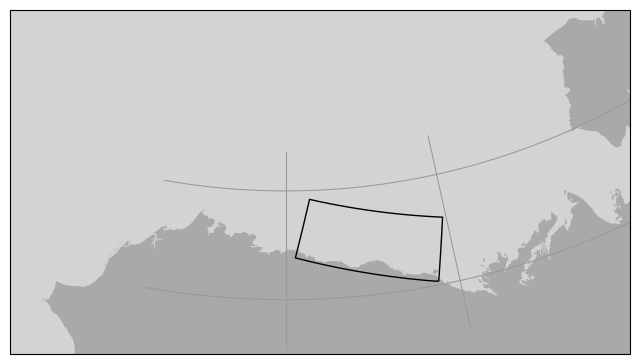

In [11]:

# initialize map
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))
ax.set_ylim(-2500000,-1500000)
ax.set_xlim(-800000,1000000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)


ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


# for key in ['era', 'ppd']:
#     ax.scatter(grids[key]['lon'][grids[key]['region']], grids[key]['lat'][grids[key]['region']], 
#                zorder=100, s = 10, transform=ccrs.PlateCarree())



line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
for lat in [69.25,72]:
    ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in [-150,-137.5]:
    ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)
    


In [13]:
# ds = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/SBSpolynya_data/open_freqs_2002-2025_M1.nc')

In [14]:
# sic = unisic.open_local_file(datetime(2020,1,1), res='6250', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', crop=[0, None, 0, None], coordinates=False, area=False, include_units=False, quiet=True)


In [15]:

# key = 'era'
# mainpath = '../data/forcing/'
# filename = f"dailymaps_{key}_v0.nc"
# ds = xr.open_dataset(mainpath+filename)

In [12]:
c1 = [140/255,210/255,245/255]
c2 = [110/255,170/255,215/255]
c3 = [80/255,130/255,185/255]
c4 = [50/255,100/255,145/255]


In [13]:
df = pd.read_csv('../data/compiled_stats.csv')

df['esei'] = vectors.comp_along_theta(df['ui'], df['vi'], 145*units('degree')) * units('cm/s').to('km/day')
df['ese10'] = 0.02*vectors.comp_along_theta(df['u10'], df['v10'], 180*units('degree'))* units('m/s').to('km/day')
# df['ese10'][df.year>=2016] = 1.3*df['ese10'][df.year>=2016]




df['si_km'] = df['si'] * units('cm/s').to('km/day')

df['e10'] = - df['u10']
# manually modify this for now since I set too strict of threshold

for cat in ['a10', 'ai', 'centermass_direction', 'max_length_direction']:
    df[f'{cat}_r'] = 90-df[f'{cat}']
    df[f'{cat}_r'][df[f'{cat}_r']<0]+=360

df['up'] = df['centermass_length'].values * np.cos(df['centermass_direction'].values*np.pi/180)
df['vp'] = df['centermass_length'].values * np.sin(df['centermass_direction'].values*np.pi/180)
                     
    
vi = (df['ui'].values, df['vi'].values)
vw = (df['u10'].values, df['v10'].values)
vp = (df['up'].values, df['vp'].values )
                              
df['ta_wi'] = vectors.turning_angle(vw,vi).magnitude
df['ta_ip'] = vectors.turning_angle(vi,vp).magnitude
df['ta_wp'] = vectors.turning_angle(vw,vp).magnitude




# identify base period
dfb = df[df['2003_2023']]

dfr = df[df.year >= 2003]



/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/810645748.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{cat}_r'][df[f'{cat}_r']<0]+=360
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/810645748.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{cat}_r'][df[f'{cat}_r']<0]+=360
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/810645748.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [14]:
for month in [12,1,2,3,4]:
    
    cond = ((dfr['sequence']!=-999)&((dfr['season_start_flag']==False)&(dfr['season_end_flag']==False)))
    cond = cond & (dfr['month']==month)
    
    print(dfr['time'][cond][dfr['extent'][cond] == np.max(dfr['extent'][cond])])
    print(dfr['sequence'][cond][dfr['extent'][cond] == np.max(dfr['extent'][cond])])
    

4851    2019-12-12
Name: time, dtype: object
4851    117
Name: sequence, dtype: int64
5489    2024-01-14
Name: time, dtype: object
5489    148
Name: sequence, dtype: int64
5232    2022-02-28
Name: time, dtype: object
5232    133
Name: sequence, dtype: int64
5697    2025-03-11
Name: time, dtype: object
5697    158
Name: sequence, dtype: int64
4368    2016-04-12
Name: time, dtype: object
4368    85
Name: sequence, dtype: int64


In [15]:
cond = ((dfr['sequence']!=-999)&((dfr['season_start_flag']==False)&(dfr['season_end_flag']==False)))
all_ss = list(set(dfr['sequence'][cond]))


In [2047]:
dfr['time'][(dfr['sequence'] == 92)]

4512    2017-04-05
4513    2017-04-06
4514    2017-04-07
4515    2017-04-08
4516    2017-04-09
4517    2017-04-10
4518    2017-04-11
Name: time, dtype: object

DatetimeIndex(['2016-12-06'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2016-12-16'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2017-01-15'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2017-01-25'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2017-01-27'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2017-04-05'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2017-04-14'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2017-04-22'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2017-12-03'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2017-12-09'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2017-12-29'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2018-01-01'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2018-01-09'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2018-01-18'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2018-02-11'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2018-03-0

Text(0, 0.5, 'Cumulative polynya extent (km^2)')

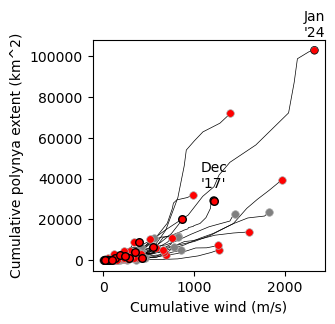

In [2055]:
fig, ax = plt.subplots(figsize=(3,3))

import matplotlib.colors as colors
cnorm = colors.Normalize(vmin=-50, vmax=50)


for ss in all_ss:
    
   


    ii = np.where((dfr['sequence'] == ss)&(dfr['first_day'] == True))[0][0]
    ff = np.where((dfr['sequence'] == ss)&(dfr['final_day'] == True))[0][0]
    
    
    st = datetime(2016,11,1)
    ed = datetime(2018,5,1)

    event_time = pd.to_datetime(dfr['time'][ii:ii+1].values)
    
    if (event_time > datetime(2015,11,1)):
        fc = 'r'
    else:
        fc = 'gray'
        
    if (event_time > st) & (event_time < ed):
        print(event_time)
        zorder = 1000
        ec = 'k'
        lw = 1

    else:
        zorder = 1
        ec = 'darkgray'
        lw = 0.5
        

#     cond = (dfr['sequence'] == ss)&(dfr['final_day']==False)
#     cum_wind = -np.cumsum(0.02*dfr['u10'][ii:ff+1]*units('m/s').to('km/day').magnitude)
    
#     cum_u_wind = -np.cumsum(0.02*dfr['u10'][ii:ff+1]*units('m/s').to('km/day').magnitude)
#     cum_v_wind = np.cumsum(0.02*dfr['v10'][ii:ff+1]*units('m/s').to('km/day').magnitude)
#     cum_wind = np.sqrt(cum_u_wind**2+cum_v_wind**2)
    
    size = 100
    
    mean_u = np.mean(dfr['u10'][ii:ff+1])
    mean_v = np.mean(dfr['v10'][ii:ff+1])
    
    
    U = dfr['u10'][ii:ff+1]
    V = dfr['v10'][ii:ff+1]
    S = np.sqrt(U**2+V**2)**2
    
    
    sum_u = np.sum(-dfr['u10'][ii:ff+1])
    sum_v = np.sum(dfr['v10'][ii:ff+1])
    sum_s = np.sqrt(sum_u**2+sum_v**2)
    
    
    mean_s = np.sqrt(mean_u**2+mean_v**2)
    
    lengths = dfr['length_145max'][ii:ff+1]
    tot_ext = np.sum(dfr['extent'][ii:ff+1])
    event_duration = dfr['event_day'][ii:ff+1]
    
    cmap = cmocean.cm.balance
    edgecolor = [0.3,0.3,0.3]
#     lw = 0.5
    size = 30
    
    angle = vectors.vector_angle(mean_u, mean_v).magnitude
    
#     plt.scatter(sum_u, sum_v, c=tot_ext,  cmap=cmap,  norm = cnorm, s=size, edgecolor=edgecolor, lw=lw)

    X = np.sum(S)

    plt.plot(np.cumsum(S), np.cumsum(dfr['extent'][ii:ff+1]), c='k', lw=0.5, zorder=-1)

    cmesh = plt.scatter(X, tot_ext, c=fc,   s=size, edgecolor=ec, lw=lw, zorder = zorder)

    
#     cmesh = plt.scatter(X, tot_ext, c=sum_v,  cmap=cmap,  norm = cnorm, s=size, edgecolor=ec, lw=lw, zorder = zorder)

    
#     if tot_ext > 30000:
#         print(dfr['time'][ii:ff])
    
    
    lift = 5000
#     if ss == 92:  
#         plt.text(X, tot_ext+lift, "Jan\n'18'", va='bottom', ha='center')
#         plt.scatter(X, tot_ext,  facecolor='None', s=size, edgecolor='k', lw=lw)
    if ss == 96:  
        plt.text(X, tot_ext+lift, "Dec\n'17'", va='bottom', ha='center')
        plt.scatter(X, tot_ext,  facecolor='None', s=size, edgecolor='k', lw=lw)
    if ss == 148:  
        plt.text(X, tot_ext+lift, "Jan\n'24", va='bottom', ha='center')
        plt.scatter(X, tot_ext,  facecolor='None', s=size, edgecolor='k', lw=lw)
#     if ss == 117:  
#         plt.text(X, tot_ext+lift, "Dec\n'19", va='bottom', ha='center')
#         plt.scatter(X, tot_ext,  facecolor='None', s=size, edgecolor='k', lw=lw)
#     if ss == 158:  
#         plt.text(X, tot_ext+lift, "Mar\n'25", va='bottom', ha='center')
#         plt.scatter(X, tot_ext,  facecolor='None', s=size, edgecolor='k', lw=lw)
# #     if ss == 133:  
# #         plt.text(X, tot_ext+1400, "Feb\n'22", va='bottom', ha='center')
# #         plt.scatter(X, tot_ext,  facecolor='None', s=size, edgecolor='k', lw=lw)
#     if ss == 85:  
#         plt.text(X, tot_ext+lift, "Apr\n'16", va='bottom', ha='center')
#         plt.scatter(X, tot_ext,  facecolor='None', s=size, edgecolor='k', lw=lw)
        
# ax.set_yscale('log')
# ax.set_xscale('log')
# plotter.add_colorbar(fig, ax, [cmesh], cb_placement='top', cb_orientation='auto', cb_width='auto', 
#              cb_length_fraction=[0.1, 0.9], cb_pad=0.025, cb_ticks='auto', cb_ticklabels='auto', cb_extend='neither',
#              cb_label='Cumulative southerly wind (m/s)', labelpad='auto', cb_label_placement='auto', cb_tick_placement='auto', 
#              tick_kwargs=None, cb_labelsize=plt.rcParams["font.size"], draw_edges=False, edge_params=['k', 2])

# colors.LogNorm(vmin=data.min(), vmax=data.max())
ax.set_xlabel('Cumulative wind (m/s)')
ax.set_ylabel('Cumulative polynya extent (km^2)')

# ax.set_ylim(0,500000)
# ax.set_xlim(-10,180)

# fig.savefig('../figures/results/cum_force_size.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [2026]:
event_time

2278   2002-12-10
Name: time, dtype: datetime64[ns]

In [2019]:
pd.to_datetime(dfr['time'][ff])

Timestamp('2010-04-14 00:00:00')

In [2021]:
st = datetime(2016,11,1)
ed = datetime(2018,5,1)

event_time = pd.to_datetime(dfr['time'][ff])

In [2022]:
if (event_time > st) & (event_time < ed):
    print(event_time)

In [11]:
# cnorm = colors.LogNorm(vmin=0.01, vmax=10e6)
# cnorm = colors.Normalize(vmin=500, vmax=5*10e3)

<>:176: SyntaxWarning: invalid escape sequence '\m'
<>:176: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/1564126474.py:176: SyntaxWarning: invalid escape sequence '\m'
  ax.text(date+2*db, all_YY.max()+25, '$\mathrm{10^4\;km^2}$ polynya extent',
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/1564126474.py:149: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([date2], all_YY[years2==2003]-1.5, marker='v', s=100, c=line_kwargs['color'], clip_on=False, zorder=10000)
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/1564126474.py:150: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequen

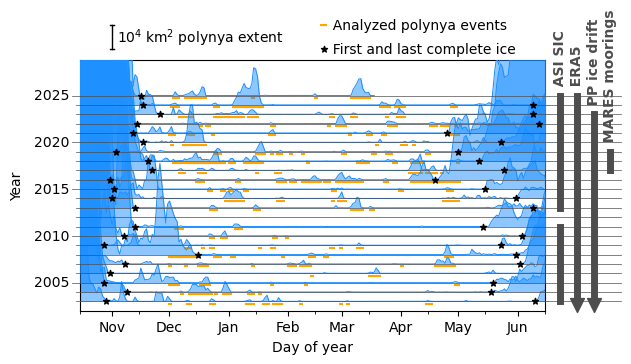

In [17]:
fig, ax = plt.subplots(figsize=(6,3.25))


years2 = np.arange(2003,2026)

all_YY = []

sizes_over_time = np.array([])


for yy, year in enumerate(years2):
    
    YY = yy * 4
    all_YY.append(YY)
    
    
    if year == 2012:
        sizes_over_time = np.append(sizes_over_time, np.full(274, np.nan))
        
    else:
    
        # open polynya data and crop to time range
        #-----------------------------------------
        DSo = xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v6.nc')
        time_range = slice(datetime(year-1,10,1), datetime(year,1,1,0) + timedelta(days=119+62))
        DSo = DSo.sel(time = time_range)

        # find first and last closure dates
        dt_og = (pd.to_datetime(DSo.time.values) - datetime(year,1,1)).days
        water_area = (DSo.polynya_extent + DSo.other_polynya_extent)/1000

        # first/last day of compact conditions
        closure_ind = np.where(water_area == 0)[0][0]
        breakup_ind = np.where(water_area == 0)[0][-1]

        # re-define dt
    #     dt = (pd.to_datetime(DS.time.values) - datetime(year,1,1)).days
        # plot polynya data
    #     ax.bar(dt_og, DSo.polynya_extent/1000, bottom=YY, color='lightgray', alpha=0.5)

        tim = pd.to_datetime(np.array([datetime(2025,1,1) + timedelta(days=dd) for dd in dt_og]))
        if year%4 == 0:
            tim_i = tim
        ext = water_area

        
        if len(ext) < 274:
            sizes_over_time = np.append(sizes_over_time, np.append(ext, np.full(274 -len(ext), np.nan)))
        else:
            sizes_over_time = np.append(sizes_over_time, ext)
                                        
        ext, _ = tseries.linear_interpolate(tim, tim, ext, max_dt = 7 * units('day'))

    #     ax.plot(tim, YY+ext, color=colors['blue3'], alpha=0.5, lw=0.5, zorder=yy)
    
#         plot_color = [0.3,0.3,0.3]
        plot_color = 'dodgerblue'
        ax.fill_between(tim, YY, YY+ext, color=plot_color, lw=0, alpha=0.5, zorder=2*yy)
        ax.plot(tim, YY+ext, color=plot_color, lw=0.75, alpha=1, zorder=2*yy)
        
        
#         ax.bar(tim, ext, bottom=YY, color=plot_color, lw=0, alpha=0.65, width=tim[1]-tim[0], zorder=yy)
        
        sc = 'k'
        ax.scatter(tim[closure_ind], YY, marker='*', color=sc, s=20, zorder=1000)
        
        if year!=2025:
            ax.scatter(tim[breakup_ind], YY, marker='*', color=sc, s=20, zorder=1000)

    

        # re-define dt
        closure_ind = np.where(pd.to_datetime(DSo.time.values) == datetime(year-1,12,1))[0][0]
        breakup_ind = np.where(pd.to_datetime(DSo.time.values) == datetime(year,4,30))[0][0]
        DS = DSo.sel(time = slice(DSo.time[closure_ind],DSo.time[breakup_ind]))
        dt = (pd.to_datetime(DS.time.values) - datetime(year,1,1)).days
        ext = DS.polynya_extent.values/1000
        tim = np.array([datetime(2025,1,1) + timedelta(days=dd) for dd in dt])

        ext, _ = tseries.linear_interpolate(tim, tim, ext, max_dt = 3 * units('day'))
        
        ec = 'orange'
        for st in tim[ext>0]:
            ax.plot([st, st+timedelta(hours=25)], [YY-1,YY-1], 
                       color=ec, lw=1.5, alpha=1, zorder=-1)

    
    if year%5 ==0:
        color1 = [0.3,0.3,0.3]
        ax.text(datetime(2024,10,10), YY, year, va='center', ha='right', clip_on=False)
        ax.plot([datetime(2024,10,11),datetime(2024,10,15)], [YY,YY], c=color1, lw=0.5, zorder=100, clip_on=False)
        ax.plot([datetime(2025,6,15),datetime(2025,7,25)], [YY,YY],  c=color1, lw=0.5, zorder=100, clip_on=False)
        ax.axhline(YY, c=color1, lw=0.5, zorder=100)
        
    else:
        color2 = [0.3,0.3,0.3]
        ax.plot([datetime(2024,10,13),datetime(2024,10,15)], [YY,YY], 
            c=color2, lw=0.5, zorder=100, clip_on=False)
        ax.plot([datetime(2025,6,15),datetime(2025,7,25)], [YY,YY], 
            c=color2, lw=0.5, zorder=100, clip_on=False)
        ax.axhline(YY, c=color2, lw=0.5, zorder=100)#-100)
    
ax.set_ylim(-4,YY+15)
    
ax.set_yticks([])

# xvals = [-61,-31,0,30,58,89,119,150]
# ticklabs = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
# for tt, lab in zip(xvals, ticklabs):
#     ax.text(tt, -26, f'1 {lab}', ha='center')


ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b')) # Display month abbreviations
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=[15,]))

ax.set_xlim(datetime(2024,10,15),datetime(2025,6,15))
    
ax.set_xlabel('Day of year')

    
all_YY = np.array(all_YY)

# label SIC record
date1 = datetime(2025,6,23)
date2 = datetime(2025,7,2)
date3 = datetime(2025,7,11)
date4 = datetime(2025,7,19)

line_kwargs = {'clip_on':False, 'lw':5, 'color': [0.3,0.3,0.3], 'zorder':1000}
dot_kwargs = {'clip_on':False, 'marker':'o', 's':15, 'c':line_kwargs['color'], 'zorder':1000}
x_kwargs = {'clip_on':False, 'marker':'x', 's':30, 'c':line_kwargs['color'], 'zorder':1000}

# draw lines
for date, pair in zip([date1, date1, date2, date3, date4],
                      ([2003, 2011], [2013, 2025], [2003, 2025], [2003, 2023], [2017, 2019])):
#     ax.plot([date, date], [all_YY[years2==pair[0]], all_YY[years2==pair[1]]], **line_kwargs)

    ax.plot([date, date], [all_YY[years2==pair[0]], all_YY[years2==pair[1]]], **line_kwargs)

# draw markers on their own
# for date, year, kwarg in zip([date1, date1, date1, date2, date3, date4, date4],
#                              [2003, 2025, 2012,2025, 2023, 2017, 2019], 
#                              [dot_kwargs, dot_kwargs, x_kwargs,dot_kwargs,
#                               dot_kwargs,dot_kwargs,dot_kwargs]):
#     ax.scatter([date], all_YY[years2==year], **kwarg)
    
# arrow markers
ax.scatter([date2], all_YY[years2==2003]-1.5, marker='v', s=100, c=line_kwargs['color'], clip_on=False, zorder=10000)
ax.scatter([date3], all_YY[years2==2003]-1.5, marker='v', s=100, c=line_kwargs['color'], clip_on=False, zorder=10000)

    
# text labels
for date, year, label in zip([date1, date2, date3, date4],
                             [2025, 2025, 2023, 2019],
                             ['  ASI SIC', '  ERA5', '  PP ice drift', "  MARES moorings"]):
    ax.text(date, all_YY[years2==year], label, ha='center',weight='bold', va='bottom',c=[0.3,0.3,0.3], rotation=90)



ax.scatter(tim[-70], all_YY.max()+20, marker='*', color=sc, s=20, clip_on=False, zorder=1000)
ax.text(tim[-70], all_YY.max()+20, '  First and last complete ice', ha='left', va='center', clip_on=False, zorder=1000)


st = tim[-72]
ax.plot([st, st+timedelta(hours=72)], [YY+30,YY+30], 
                       color=ec, lw=1.5, alpha=1, clip_on=False, zorder=1000)
ax.text(tim[-70], all_YY.max()+30, '  Analyzed polynya events', ha='left', va='center', clip_on=False, zorder=1000)


date = datetime(2024,11,1)
db = timedelta(hours=30)
ax.plot([date, date], [all_YY.max()+20, all_YY.max()+30], lw=1,c='k',  clip_on=False)
ax.plot([date-db, date+db], [all_YY.max()+20, all_YY.max()+20], lw=1,c='k',  clip_on=False)
ax.plot([date-db, date+db], [all_YY.max()+30, all_YY.max()+30], lw=1,c='k',  clip_on=False)
ax.text(date+2*db, all_YY.max()+25, '$\mathrm{10^4\;km^2}$ polynya extent', 
        ha='left', va='center', clip_on=False, zorder=1000)


# color=[0.6,0.6,0.6]
# ax.plot([datetime(2024,12,4), datetime(2025,4,29)], 
#         [all_YY.max()+25, all_YY.max()+25], lw=7, c=color, clip_on=False)
# for date in [datetime(2024,12,1), datetime(2025,4,30)]:
#     ax.plot([date,date], [all_YY.min()-3, all_YY.max()+25], 
#             lw=2, ls='solid', alpha=0.5, c=color, clip_on=False)


ax.set_ylabel('Year', labelpad=40)

# fig.savefig('../figures/results/identified_events_v2.png', dpi=400, bbox_inches='tight', pad_inches=0)


time_grid, year_grid = np.meshgrid(tim_i, years2)
sizes_over_time = np.reshape(sizes_over_time, (len(years2), int(len(sizes_over_time)/len(years2))))

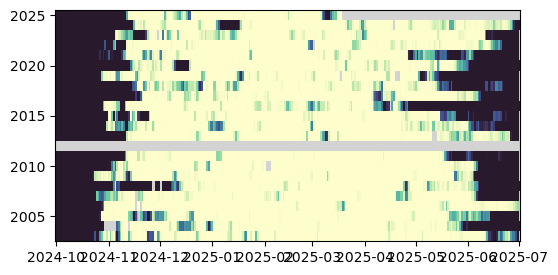

In [23]:
fig, ax = plt.subplots(figsize=(6,3))
ax.patch.set_facecolor('lightgray')

bounds = np.array([0,1,155,545,1700,5000,10e6])/1000
# cmap = matplotlib.colors.ListedColormap(['whitesmoke', c1,c2,c3,c4,'k'])

cmap = matplotlib.colors.ListedColormap(['white', 
                                         cmocean.cm.haline(0.9),
                                         cmocean.cm.haline(0.6),
                                         cmocean.cm.haline(0.3),
                                         cmocean.cm.haline(0.1),
                                         'k'])
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# plt.pcolormesh(time_grid, year_grid, sizes_over_time,
#                cmap=cmap, norm=norm)

plt.pcolormesh(time_grid, year_grid, sizes_over_time,
               cmap=cmocean.cm.deep, vmin=0, vmax=5)
#                vmin=0.0, vmax=2, cmap=cmocean.cm.haline_r)




In [24]:
colors = {}
colors['blue1'] = [45/255,150/255,250/255]
colors['blue2'] = [111/255,170/255,220/255]
colors['blue3'] = [0/255,129/255,243/255]

In [25]:
all_polynya_sizes = daily_data['pol']['extent'][daily_data['pol']['extent']>0]

plt.hist(all_polynya_sizes)

NameError: name 'daily_data' is not defined

## Grab stats over time by month and year

In [26]:


def plot_angles(ax, X, cond, clip):
    label_nums(ax, X, np.sum(cond), clip)
    plot_dist(ax, X-0.15, *angle_distribution(dfb, cond, 'atm'), clip, bins = np.arange(0,361,7.5), yscale=1)
    plot_dist(ax, X+0.15, *angle_distribution(dfb, cond, 'ice'), clip, bins = np.arange(0,361,7.5), yscale=1)
    
#     plot_point(ax, X-0.15, *speed_distribution(df_base, cond, 'atm'))
#     plot_point(ax, X+0.15, *speed_distribution(df_base, cond, 'ice'))    
    
        
def plot_temps(ax, X, cond, clip):
    plot_dist(ax, X, *temp_distribution(df_base, cond), clip, bins = np.arange(-40,0,2), yscale=1)

def plot_msls(ax, X, cond, clip):
    plot_dist(ax, X, *msl_distribution(df_base, cond), clip, bins = np.arange(980,1060,4), yscale=1)
    
def plot_speeds(ax, X, cond, clip):
    plot_dist(ax, X-0.15, *speed_distribution(dfb, cond, 'atm'), clip, bins = np.arange(0,20,1), yscale=1)
    plot_dist(ax, X+0.15, *speed_distribution(dfb, cond, 'ice'), clip, bins = np.arange(0,40,2), yscale=0.5)    

#     plot_point(ax, X-0.15, *speed_distribution(df_base, cond, 'atm'))
#     plot_point(ax, X+0.15, *speed_distribution(df_base, cond, 'ice'))    
    
    
def plot_dist(ax, X, y, Y, color, bg_color, clip, bins = np.arange(0,40,2), yscale = 1, scale = 5, show_mode = False):
    
    h = plotter.quick_hist(y, bin_edges=bins)
    
    if show_mode == True:
        ax.scatter(X, h['centers'][np.argmax(h['prob'])], marker='s', edgecolor=color, facecolor='None',clip_on=clip)
    else:
        ax.scatter(X, yscale*Y, marker='o', edgecolor=color, facecolor='None', s=40, clip_on=clip, zorder=100)
        
#     ax.scatter(X, h['centers'][np.argmax(h['prob'])], marker='o', edgecolor='None', facecolor=color, s=20, clip_on=clip)
    ax.fill_betweenx(yscale*h['edges'][:-1], X - scale*h['prob']/2, X + scale*h['prob']/2, 
                     lw=0, color=bg_color, alpha=0.5, zorder=-1, clip_on=clip)   
    
#     ax.barh(h['centers'], scale*h['prob'], height=h['w'], left= X - scale*h['prob']/2, align='center', 
#             color=bg_color, alpha=0.5, zorder=-1, clip_on=clip)
    

def plot_point(ax, X, y, Y, color, bg_color):
    ax.scatter(X, Y, c=color, clip_on=False)
    ax.scatter(np.linspace(X-0.05,X+0.05, len(y)), y, c=bg_color, s=1, zorder=-1, clip_on=False)

    
def size_distribution(df, cond):

    all_sizes = df['extent'][cond]/1000
    mean_size = np.nanmean(all_sizes)
    print(mean_size)
    color = 'k'
    bg_color = 'gray'

    return all_sizes, mean_size, color, bg_color


def msl_distribution(df, cond):

    all_ = df['msl'][cond]/100
    mean_ = np.nanmean(all_)
    color = 'k'
    bg_color = 'gray'

    return all_, mean_, color, bg_color

def temp_distribution(df, cond):

    all_ = df['t2m'][cond]
    mean_ = np.nanmean(all_)
    color = 'k'
    bg_color = 'gray'

    return all_, mean_, color, bg_color


def speed_distribution(df, cond, group):
    
    if group == 'atm':
        all_speeds = df['s10'][cond]
        mean_speed = np.nanmean(all_speeds)
        color = 'dodgerblue'
        bg_color = 'dodgerblue'
    else:
        all_speeds = df['si'][cond] #* units('cm/s').to('km/day').magnitude
        mean_speed = np.nanmean(all_speeds)
        color = 'r'
        bg_color = 'lightcoral'

    return all_speeds, mean_speed, color, bg_color

def angle_distribution(df, cond, group):

    if group == 'atm':
        U = df['u10'][cond]
        V = df['v10'][cond]
        color = 'dodgerblue'
        bg_color = 'dodgerblue'
    else:
        U = df['ui'][cond]
        V = df['vi'][cond]
        color = 'r'
        bg_color = 'lightcoral'

    all_angles = np.array([vectors.vector_angle(u,v).magnitude for u,v in zip(U,V)])
    mean_angle = vectors.vector_angle(np.nanmean(U), np.nanmean(V)).magnitude
    
    if mean_angle < 0:
        mean_angle+=360
    all_angles[all_angles<0] += 360

    return all_angles, mean_angle, color, bg_color

def label_nums(ax, x, N, clip):
    ax.text(x, -10, N, ha='center',va='bottom', size=5, clip_on=clip)
    
    


### Identify which days to include for each event

### Define direction ranges

In [1894]:
# wind_dir_cond = (DF['a10_r'] > 260) & (DF['a10_r'] < 300)
# ice_dir_cond = (DF['ai_r'] > 270) & (DF['ai_r'] < 315)
# wind_speed_cond = DF['s10'] > 7


# dir_conds = {}
# dir_conds['wind'] = (DF['a10_r'] > 260) & (DF['a10_r'] < 300)
# dir_conds['ice'] = (DF['ai_r'] > 270) & (DF['ai_r'] < 315)

# dir_conds = {}
# dir_conds['wind'] = (DF['a10_r'] > 260) & (DF['a10_r'] < 300)
# dir_conds['ice'] = (DF['ai_r'] > 270) & (DF['ai_r'] < 315)


def dir_conds(dff, cat):
    
    if cat == 'wind':
        
#         dir_cond = (dff['a10_r'] > 260) & (dff['a10_r'] < 305)
#         dir_cond = (dff['a10_r'] > 260) & (dff['a10_r'] < 300)
        dir_cond = (dff['a10_r'] > 260) & (dff['a10_r'] < 305)
        
    elif cat == 'ice':
        
        dir_cond = (dff['ai_r'] > 270) & (dff['ai_r'] < 315)
#         dir_cond = (dff['ai_r'] > 270) & (dff['ai_r'] < 315)

    elif cat == 'poly':
        
        dir_cond = (dff['centermass_direction_r'] > 280) & (dff['centermass_direction_r'] < 330)
        
    return dir_cond

def speed_conds(dff, cat):
    
    if cat == 'wind':
        speed_cond = (dff['s10'] > 6)

#         speed_cond = np.copy(dff['s10'] > 8.5)
#         speed_cond[dff.year>=2016] = np.copy(dff['s10'][dff.year>=2016] > 6)

#         speed_cond = np.copy(dff['s10'] > 7.5)
#         speed_cond[dff.year>=2016] = np.copy(dff['s10'][dff.year>=2016] > 5.5)
        
#         years = np.arange(2003,2026)
#         ws_thresh = np.linspace(9,5.5, len(years))
#         speed_cond = np.copy(dff['s10'] > 10)
#         for year in years:
#             speed_cond[dff.year==year] = (dff['s10'][dff.year==year] > ws_thresh[years==year][0])


    elif cat == 'ice':
        speed_cond = (dff['si_km'] > 10)

    return speed_cond

speed_bins = {}
speed_bins['wind'] = np.arange(0,17,1)
speed_bins['ice'] = np.arange(0,35,2)



In [1895]:
np.sum(dir_conds(DF[DF.extent>0], 'poly'))/np.sum(DF.extent>0)

0.8959660297239915

In [1896]:
np.sum(dir_conds(DF[DF.extent>0], 'wind'))/np.sum(DF.extent>0)

0.7961783439490446

In [1897]:
np.sum(dir_conds(DF[DF.extent>0], 'ice'))/np.sum(DF.extent>0)

0.7770700636942676

<>:151: SyntaxWarning: invalid escape sequence '\m'
<>:151: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/1890841741.py:151: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Polynya\nextent\n($\\times\mathrm{10^3\;km^2}$)', rotation=0, labelpad=25, va='center')


13
133


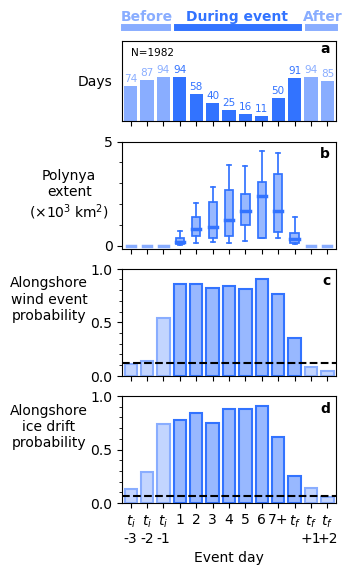

In [1898]:
fig, axs = plt.subplots(4,1,figsize=(2.75,6), gridspec_kw={'height_ratios':[0.75,1,1,1]})


#=============
L = 6
#=============


#=============
DF = dfb
#=============
print(len(list(set(DF['sequence'][DF['event_length']>L]))))
print(len(list(set(DF['sequence'][DF['event_length']<=L]))))

shoulder = (DF['season_start_flag'] + DF['season_end_flag'])


comp_ = (DF.extent==0)
comp_[(DF.day_before_event>=-3)]=False
comp_[(DF.day_after_event<=2)&(DF.day_after_event>-999)]=False

def plot_percentiles(ax, x, data, c='r'):
    ax.scatter(x, np.nanpercentile(data, 50), s=10, c=c)
    ax.scatter(x, np.nanpercentile(data, 25), s=5, c=c)
    ax.scatter(x, np.nanpercentile(data, 75), s=5, c=c)
    
def plot_means(ax, x, data, c='r'):
    ax.scatter(x, np.nanmean(data), s=10, c=c)
    ax.scatter(x, np.nanmean(data)+np.nanstd(data), s=5, c=c)
    ax.scatter(x, np.nanmean(data)-np.nanstd(data), s=5, c=c)
    
    
days_before = np.array([-4,-3,-2,-1])
labels_before = np.array(['$t_{i}$'f'\n{dd}' for dd in days_before])
conds_before = [(DF['day_before_event'] == dd)&(DF['before_event_length']>1) for dd in days_before]

days_during = np.arange(1,L+1)
labels_during = np.array([f'{dd}' for dd in days_during])
conds_during = [((DF['event_day'] == dd)&(shoulder==False))&(DF['final_day'] == False) for dd in days_during]
conds_during[0] = ((DF['event_day'] == 1)&(DF['season_start_flag']==False))&(DF['single_day']==False)


days_more = np.array([L+1])
labels_more = np.array([f'{L+1}+'])
conds_more = [((DF['event_day'] > L)&(DF['final_day'] == False))&(shoulder==False)]

# conds_more = [((df['final_day'] == True)&(df['first_day']==False))]

day_final = np.array([L+2])
labels_final = np.array(['$t_{f}$'])
conds_final = [((DF['final_day'] == True)&(shoulder==False))&(DF['single_day']==False)]   

days_after = np.array([1,2,3])
labels_after = np.array(['$t_{f}$'f'\n+{dd}' for dd in days_after])
conds_after = [(DF['day_after_event'] == dd)&(DF['after_event_length']>1) for dd in days_after]   


x_values = np.concatenate((1+days_before, days_during, days_more, day_final, 2+L+days_after))
x_labels = np.concatenate((labels_before, labels_during, labels_more, labels_final, labels_after))
all_cond = np.concatenate((conds_before, conds_during, conds_more, conds_final, conds_after))

    
    
color1 = [50/255,115/255, 255/255]   
color2 = [137/255,173/255, 255/255]   
    
    
ax = axs[0]
# ax.axhline(len(list(set(df.sequence))), c='lightgray', zorder=-10)
ax.set_ylim(0,170)
ax.set_yticks([])
ax.set_ylabel('Days', rotation=0, labelpad=20, va='center')
for dd, cond in zip(x_values[1:-1], all_cond[1:-1]):
    
    if (dd >0)&(dd < 9):
        ax.bar(dd, np.sum(cond), color=color1)
        ax.text(dd, np.sum(cond)+5, np.sum(cond), 
                color=color1, va='bottom', ha='center', size=7.5)
    else:
        ax.bar(dd, np.sum(cond), color=color2)
        ax.text(dd, np.sum(cond)+5, np.sum(cond), 
                color=color2, va='bottom', ha='center', size=7.5)
ax.text(-2, 140, f'N={np.sum(comp_):.0f}', c='k', size = 7.5,zorder=0)


for ax in axs:
    ax.set_xlim(x_values.min()-0.75+1.25, x_values.max()+0.75-1.25)
    ax.set_xticks(x_values[1:-1])
    ax.set_xticklabels([])
axs[-1].set_xticklabels(x_labels[1:-1]);
# plt.xticks(fontsize=9)



for ax in axs[2:]:
    ax.set_ylim(0,1)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))


axs[2].set_ylabel('Alongshore\nwind event\nprobability', rotation=0, labelpad=30)
axs[3].set_ylabel('Alongshore\nice drift\nprobability', rotation=0, labelpad=30)

ax = axs[2]

for ax, cat in zip(axs[2:], ['wind', 'ice']):
    
    wind_prob = np.array([])
    for dd, cond in zip(x_values, all_cond):
        cond1 = cond & (dir_conds(DF, cat))& speed_conds(DF, cat)
        wind_prob = np.append(wind_prob, np.sum(cond1)/np.sum(cond))
        
    width = 0.75    
        
    ax.bar(x_values[4:-3], wind_prob[4:-3], width=width,color = color1, ls='solid',  alpha=0.5, zorder=1)
    ax.bar(x_values[:4], wind_prob[:4],width=width, color = color2, ls='solid',  alpha=0.5, zorder=1)
    ax.bar(x_values[-3:], wind_prob[-3:],width=width, color = color2, ls='solid',  alpha=0.5, zorder=1)
    
    
    ax.bar(x_values[4:-3], wind_prob[4:-3], width=width,facecolor='None', edgecolor = color1, ls='solid', lw=1.5, alpha=1, zorder=1)
    ax.bar(x_values[:4], wind_prob[:4], width=width,facecolor='None', edgecolor = color2, ls='solid', lw=1.5, alpha=1, zorder=1)
    ax.bar(x_values[-3:], wind_prob[-3:], width=width,facecolor='None', edgecolor = color2, ls='solid', lw=1.5, alpha=1, zorder=1)
    
#     ax.plot(x_values, wind_prob, color = 'k', ls='solid', marker='s', alpha=1, zorder=1)

    cond = comp_
    cond1 = cond & (dir_conds(DF, cat)&speed_conds(DF, cat))
    ax.axhline(np.sum(cond1)/np.sum(cond), ls='dashed', lw=1.5,  c = 'k', zorder=2)




    
axs[-1].set_xlabel('Event day')

for aa, ax in enumerate(axs):
#     ax.text(1.01, 0.95, '(a)', ha='left', va='top', weight='bold', clip_on=False, transform = ax.transAxes)
    if aa == 0:
        ax.text(0.975, 0.99, f'{chr(97+aa)}', 
                ha='right', va='top', weight='bold', clip_on=False, transform = ax.transAxes)

    else:
        ax.text(0.975, 0.95, f'{chr(97+aa)}', 
                ha='right', va='top', weight='bold', clip_on=False, transform = ax.transAxes)

    
C = 'k'

ax = axs[1]
ax.set_ylim(-0.15,5)
ax.set_ylabel('Polynya\nextent\n($\\times\mathrm{10^3\;km^2}$)', rotation=0, labelpad=25, va='center')
VAR = 'extent'
for dd, cond in zip(x_values, all_cond):
    
    bf=0.25
    
    if (dd >= 1)&(dd<9):
        color = color1
    else:
        color = color2
        
#     ax.scatter(np.linspace(dd-bf,dd+bf, np.sum(cond)), DF[VAR][cond]/10e2,
#                c=color, s=5, zorder=1)
    
    LW = 1.25
    
    bottom = np.nanpercentile(DF[VAR][cond], 25)/10e2
    middle = np.nanpercentile(DF[VAR][cond], 50)/10e2
    top = np.nanpercentile(DF[VAR][cond], 75)/10e2
    high = np.nanpercentile(DF[VAR][cond], 90)/10e2
    low = np.nanpercentile(DF[VAR][cond], 10)/10e2
    height=(top-bottom)
    rectangle = patches.Rectangle((dd-bf, bottom), 2*bf, height, lw=LW, edgecolor='None', facecolor=color, alpha=0.5)
    ax.add_patch(rectangle)
    rectangle = patches.Rectangle((dd-bf, bottom), 2*bf, height, lw=LW, edgecolor=color, facecolor='None')
    ax.add_patch(rectangle)
#     ax.plot(rectangle)
    
    ax.plot([dd-bf,dd+bf],[middle, middle], c = color, lw=2*LW, zorder=1)
    ax.plot([dd,dd],[top, high], c = color, lw=LW, zorder=1)
    ax.plot([dd,dd],[low, bottom], c = color, lw=LW, zorder=1)
    
    bb = bf/2
    ax.plot([dd-bb,dd+bb],[high, high], c = color, lw=LW, zorder=1)
    ax.plot([dd-bb,dd+bb],[low, low], c = color, lw=LW, zorder=1)
    
#     ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 25)/10e2,
#             np.nanpercentile(DF[VAR][cond], 75)/10e2], c=color, zorder=1)
    
#     ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 10)/10e2,
#             np.nanpercentile(DF[VAR][cond], 90)/10e2], c=color, zorder=1)

ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    
    
# Get the y-axis tick labels
xtick_labels = axs[-1].get_xticklabels()

# Change the color of specific y-axis tick labels
# for i, label in enumerate(xtick_labels):
#     if (i >=3)&(i<11):  # Change every other y-axis label to green
#         label.set_color(color1)
#     else:
#         label.set_color(color2)

        
ax = axs[0]

yy = 200
ax.plot([0.8,8.2], [yy,yy], c=color1, lw=5, clip_on=False)
ax.text(4.5,yy+7, 'During event', weight='bold', c=color1, va='bottom', ha='center', clip_on=False)
ax.plot([-2.4,0.2], [yy,yy], c=color2, lw=5, clip_on=False)
ax.text(-1,yy+7, 'Before', weight='bold', c=color2, va='bottom', ha='center', clip_on=False)
ax.plot([8.8,10.4], [yy,yy], c=color2, lw=5, clip_on=False)
ax.text(9.75,yy+7, 'After', weight='bold', c=color2, va='bottom', ha='center', clip_on=False)
fig.savefig('../figures/results/comp_time.png', dpi=400, bbox_inches='tight')

<>:112: SyntaxWarning: invalid escape sequence '\m'
<>:127: SyntaxWarning: invalid escape sequence '\m'
<>:147: SyntaxWarning: invalid escape sequence '\m'
<>:202: SyntaxWarning: invalid escape sequence '\m'
<>:112: SyntaxWarning: invalid escape sequence '\m'
<>:127: SyntaxWarning: invalid escape sequence '\m'
<>:147: SyntaxWarning: invalid escape sequence '\m'
<>:202: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/505133768.py:112: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Polynya\nextent\n($\\times\mathrm{10^3\;km^2}$)')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/505133768.py:127: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Wind speed\n($\mathrm{m\;s^{-1}}$)')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/505133768.py:147: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Ice speed\n($\mathrm{km\;d^{-1}}$)')
/var/folders/p8/hz449fpx6nsc

13
133


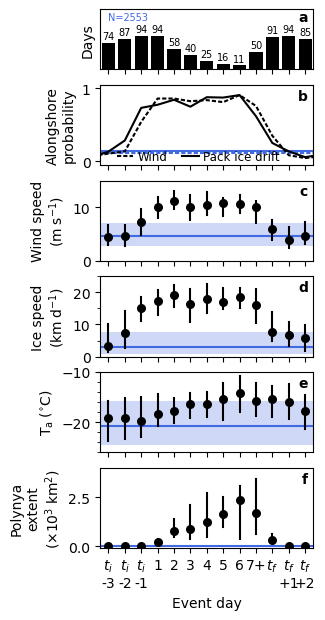

In [1899]:
fig, axs = plt.subplots(6,1,figsize=(2.75,7), gridspec_kw={'height_ratios':[0.75,1,1,1,1,1]})


#=============
L = 6
#=============

var = 't2m'

#=============
DF = dfb
#=============
print(len(list(set(DF['sequence'][DF['event_length']>L]))))
print(len(list(set(DF['sequence'][DF['event_length']<=L]))))

shoulder = (DF['season_start_flag'] + DF['season_end_flag'])


comp_ = (DF.extent==0)

def plot_percentiles(ax, x, data, c='r'):
    ax.scatter(x, np.nanpercentile(data, 50), s=10, c=c)
    ax.scatter(x, np.nanpercentile(data, 25), s=5, c=c)
    ax.scatter(x, np.nanpercentile(data, 75), s=5, c=c)
    
def plot_means(ax, x, data, c='r'):
    ax.scatter(x, np.nanmean(data), s=10, c=c)
    ax.scatter(x, np.nanmean(data)+np.nanstd(data), s=5, c=c)
    ax.scatter(x, np.nanmean(data)-np.nanstd(data), s=5, c=c)
    
    
    
days_before = np.array([-4,-3,-2,-1])
labels_before = np.array(['$t_{i}$'f'\n{dd}' for dd in days_before])
conds_before = [(DF['day_before_event'] == dd)&(DF['before_event_length']>1) for dd in days_before]

days_during = np.arange(1,L+1)
labels_during = np.array([f'{dd}' for dd in days_during])
conds_during = [((DF['event_day'] == dd)&(shoulder==False))&(DF['final_day'] == False) for dd in days_during]
conds_during[0] = ((DF['event_day'] == 1)&(DF['season_start_flag']==False))&(DF['single_day']==False)


days_more = np.array([L+1])
labels_more = np.array([f'{L+1}+'])
conds_more = [((DF['event_day'] > L)&(DF['final_day'] == False))&(shoulder==False)]

# conds_more = [((df['final_day'] == True)&(df['first_day']==False))]

day_final = np.array([L+2])
labels_final = np.array(['$t_{f}$'])
conds_final = [((DF['final_day'] == True)&(shoulder==False))&(DF['single_day']==False)]   

days_after = np.array([1,2,3])
labels_after = np.array(['$t_{f}$'f'\n+{dd}' for dd in days_after])
conds_after = [(DF['day_after_event'] == dd)&(DF['after_event_length']>1) for dd in days_after]   


x_values = np.concatenate((1+days_before, days_during, days_more, day_final, 2+L+days_after))
x_labels = np.concatenate((labels_before, labels_during, labels_more, labels_final, labels_after))
all_cond = np.concatenate((conds_before, conds_during, conds_more, conds_final, conds_after))






    
ax = axs[0]
# ax.axhline(len(list(set(df.sequence))), c='lightgray', zorder=-10)
ax.set_ylim(0,170)
ax.set_yticks([])
ax.set_ylabel('Days')
for dd, cond in zip(x_values[1:-1], all_cond[1:-1]):
    ax.bar(dd, np.sum(cond), color='k')
    ax.text(dd, np.sum(cond)+5, np.sum(cond), 
            color='k', va='bottom', ha='center', size=7)
ax.text(-2, 140, f'N={np.sum(comp_):.0f}', c='royalblue', size = 7,zorder=0)


for ax in axs:
    ax.set_xlim(x_values.min()-0.75+1.25, x_values.max()+0.75-1.25)
    ax.set_xticks(x_values[1:-1])
    ax.set_xticklabels([])
axs[-1].set_xticklabels(x_labels[1:-1]);
# plt.xticks(fontsize=9)

# for dd, cond in zip(x_values, all_cond):
#     angles = np.copy(df['a10'][cond])
#     angles[angles<0]+=360
#     angle_of_mean = vectors.vector_angle(np.nanmean(df['u10'][cond]), np.nanmean(df['v10'][cond])).magnitude
#     if angle_of_mean < 0:
#         angle_of_mean+=360
#     plot_dist(ax, dd, angles, angle_of_mean, 
#           'r', 'lightcoral', False, bins = np.arange(0, 361,10), yscale = 1, scale=3, show_mode=False)
    
# for dd, cond in zip(x_values, all_cond):
#     angles = np.copy(df['ai'][cond])
#     angles[angles<0]+=360
#     angle_of_mean = vectors.vector_angle(np.nanmean(df['ui'][cond]), np.nanmean(df['vi'][cond])).magnitude
#     if angle_of_mean < 0:
#         angle_of_mean+=360
#     plot_dist(ax, dd, angles, angle_of_mean, 
#           'b', 'dodgerblue', False, bins = np.arange(0, 361,10), yscale = 1, scale=3)


# plt.axhline(165, c='k', ls='dashed', zorder=-1)

C = 'k'

ax = axs[5]
ax.set_ylim(-0.1,4)
ax.set_ylabel('Polynya\nextent\n($\\times\mathrm{10^3\;km^2}$)')
VAR = 'extent'
for dd, cond in zip(x_values, all_cond):
    ax.scatter(dd,np.nanpercentile(DF[VAR][cond], 50)/10e2, facecolor = 'k', edgecolor=C, s=30, zorder=1)
#     ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 5)/10e2,
#             np.nanpercentile(DF[VAR][cond], 95)/10e2], c='darkgray', zorder=1)
    ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 25)/10e2,
            np.nanpercentile(DF[VAR][cond], 75)/10e2], c=C, zorder=1)
ax.axhline(0, c='royalblue', zorder=-1)
    
    
C = 'k'

ax = axs[2]
ax.set_ylim(0,15)
ax.set_ylabel('Wind speed\n($\mathrm{m\;s^{-1}}$)')
VAR = 's10'
for dd, cond in zip(x_values, all_cond):
    ax.scatter(dd,np.nanpercentile(DF[VAR][cond], 50), facecolor = C, edgecolor=C, s=30, zorder=1)
#     ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 5),
#             np.nanpercentile(DF[VAR][cond], 95)], c='darkgray', zorder=1)
    ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 25),
            np.nanpercentile(DF[VAR][cond], 75)], c=C, zorder=1)
    
ax.axhline(np.nanpercentile(DF[VAR][DF.extent==0], 50), c='royalblue', zorder=-1)
ax.fill_between(x=ax.get_xlim(), 
                y1=np.nanpercentile(DF[VAR][DF.extent==0], 25), 
                y2=np.nanpercentile(DF[VAR][DF.extent==0], 75), 
                color='royalblue',  lw=0,
                interpolate=True, alpha=0.25, zorder=-2)
# ax.axhline(7, c='gray', ls='dotted', zorder=1)
# ax.text(7.35, 7.5, '$\mathrm{7\;m\;s^{-1}}$', c='gray',size = 9.5, zorder=0)

ax = axs[3]
ax.set_ylim(0,25)
ax.set_ylabel('Ice speed\n($\mathrm{km\;d^{-1}}$)')
VAR = 'si_km'
for dd, cond in zip(x_values, all_cond):
    ax.scatter(dd,np.nanpercentile(DF[VAR][cond], 50), facecolor = C, edgecolor=C, s=30, zorder=1)
#     ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 5),
#             np.nanpercentile(DF[VAR][cond], 95)], c='darkgray', zorder=1)
    ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 25),
            np.nanpercentile(DF[VAR][cond], 75)], c=C, zorder=1)
    
ax.axhline(np.nanpercentile(DF[VAR][DF.extent==0], 50), c='royalblue', zorder=-1)
ax.fill_between(x=ax.get_xlim(), 
                y1=np.nanpercentile(DF[VAR][DF.extent==0], 25), 
                y2=np.nanpercentile(DF[VAR][DF.extent==0], 75), 
                color='royalblue',  lw=0,
                interpolate=True, alpha=0.25, zorder=-2)

# ax.axhline(10, c='gray', ls='dotted', zorder=0)
# ax.text(3, 5.25, '$\mathrm{10\;km\;d^{-1}}$', c='gray', size = 9.5,zorder=0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))

ax = axs[1]
ax.set_ylabel('Alongshore\nprobability')
ax.set_ylim(-0.05,1.05)
ax.plot([-1.5,-0.5],[.075,.075], c='k', ls='dashed', dashes=(2, 1), zorder=1)
ax.plot([2.5,3.5],[.075,.075], c='k', ls='solid', zorder=1)
ax.text(-0.25, 0.15, 'Wind', size = 8.5, va = 'top', ha='left', c='k', zorder=0)
ax.text(3.75, 0.15, 'Pack ice drift', size = 8.5,va = 'top', ha='left',  c='k', zorder=0)


ice_prob = np.array([])
wind_prob = np.array([])
for dd, cond in zip(x_values, all_cond):
    
    cond1 = cond & (dir_conds(DF, 'ice')&speed_conds(DF, 'ice'))
    cond2 = cond & (dir_conds(DF, 'wind')&speed_conds(DF, 'wind'))
    
    ice_prob = np.append(ice_prob, np.sum(cond1)/np.sum(cond))
    wind_prob = np.append(wind_prob, np.sum(cond2)/np.sum(cond))
    
ax.plot(x_values, ice_prob, color = 'k', alpha=1, zorder=1)
ax.plot(x_values, wind_prob, color = 'k', ls='dashed', dashes=(2, 1), alpha=1, zorder=1)

    
cond = comp_
cond1 = cond & (dir_conds(DF, 'ice')&speed_conds(DF, 'ice'))
cond2 = cond & (dir_conds(DF, 'wind')&speed_conds(DF, 'wind'))
ax.axhline(np.sum(cond2)/np.sum(cond), c = 'royalblue', zorder=-2)
ax.axhline(np.sum(cond1)/np.sum(cond), c = 'royalblue', ls='dashed',dashes=(2, 1), zorder=-2)



    
ax = axs[4]
ax.set_ylim(-26,-10)
ax.set_ylabel('$\mathrm{T_{a}\;(^{\circ}C}$)')
VAR = 't2m'
for dd, cond in zip(x_values, all_cond):
    ax.scatter(dd,np.nanpercentile(DF[VAR][cond], 50), facecolor = C, edgecolor=C, s=30, zorder=1)
#     ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 5),
#             np.nanpercentile(DF[VAR][cond], 95)], c='darkgray', zorder=1)
    ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 25),
            np.nanpercentile(DF[VAR][cond], 75)], c=C, zorder=1)
    
ax.axhline(np.nanpercentile(DF[VAR][DF.extent==0], 50), c='royalblue', zorder=-1)
ax.fill_between(x=ax.get_xlim(), 
                y1=np.nanpercentile(DF[VAR][DF.extent==0], 25), 
                y2=np.nanpercentile(DF[VAR][DF.extent==0], 75), 
                color='royalblue',  lw=0,
                interpolate=True, alpha=0.25, zorder=-2)
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))
    
    
    
    
axs[-1].set_xlabel('Event day')
#     plot_dist(ax, dd, df['t2m'][cond], np.nanmean(df['t2m'][cond]), 
#           'r', 'lightcoral', True, bins = np.arange(-36,4,2), yscale = 1)
    
    
# ax = axs[4]
# ax.set_ylim(-500,10000)
# for dd, cond in zip(x_values, all_cond):
#     ax.axhline(np.nanmean(df['extent'][df.extent==0]), c='r', zorder=-1)
#     plot_dist(ax, dd, df['extent'][cond], np.nanmean(df['extent'][cond]), 
#           'r', 'lightcoral', True, bins = np.arange(0,25000,500), yscale = 1)


for aa, ax in enumerate(axs):
#     ax.text(1.01, 0.95, '(a)', ha='left', va='top', weight='bold', clip_on=False, transform = ax.transAxes)
    if aa == 0:
        ax.text(0.975, 0.99, f'{chr(97+aa)}', ha='right', va='top', weight='bold', clip_on=False, transform = ax.transAxes)

    else:
        ax.text(0.975, 0.95, f'{chr(97+aa)}', ha='right', va='top', weight='bold', clip_on=False, transform = ax.transAxes)

    
# plt.ylim(-10,300)
#     plt.scatter(dd, np.nanmean(df['esei'][(df['event_day'] == dd)&(shoulder==False)]), color = 'k')


# fig.savefig('../figures/results/comp_time_v4.png', dpi=400, bbox_inches='tight')

In [1900]:

#=============
DF = dfb
#=============

# not_last_day = (DF.final_day == False)
# not_last_day[DF.single_day == True] == True

not_last_day = (DF.final_day == False)
not_last_day[DF.single_day == True] = True

print(np.nanpercentile(DF.si_km[((DF.extent > 0)&(not_last_day))+(DF.day_before_event==-1)], 25))
print(np.nanpercentile(DF.s10[((DF.extent > 0)&(not_last_day))+(DF.day_before_event==-1)], 25))

# print(np.nanpercentile(DF.si_km[((DF.extent > 0)&(not_last_day))], 25))
# print(np.nanpercentile(DF.s10[((DF.extent > 0)&(not_last_day))], 25))



10.97569646345195
6.508233014464062


In [1901]:
np.nanpercentile(DF.s10[DF.extent == 0], 85)

8.368934065296683

In [1902]:
cond = (DF.extent==0)
cond1 = cond & (dir_conds(DF, 'wind') & speed_conds(DF, 'wind'))
cond2 = cond & (dir_conds(DF, 'wind'))
# ax.axhline(dd,np.sum(cond2)/np.sum(cond), color = 'royalblue', alpha=0.2,  zorder=1)
# ax.axhline(dd,np.sum(cond1)/np.sum(cond), color = 'royalblue', zorder=1)

In [1903]:
dir_conds(DF, 'wind') & speed_conds(DF, 'wind')

2269    False
2270    False
2271    False
2272     True
2273    False
        ...  
5440    False
5441    False
5442    False
5443    False
5444     True
Length: 3176, dtype: bool

In [108]:
def plot_dist(ax, X, y, Y, color, bg_color, clip, bins = np.arange(0,40,2), yscale = 1):
    h = plotter.quick_hist(y, bin_edges=bins)
    
    ax.scatter(X, yscale*Y, marker='o', edgecolor=color, facecolor='None', s=40, clip_on=clip, zorder=100)
#     ax.scatter(X, h['centers'][np.argmax(h['prob'])], marker='s', edgecolor=color, facecolor='None',clip_on=clip)
#     ax.scatter(X, h['centers'][np.argmax(h['prob'])], marker='o', edgecolor='None', facecolor=color, s=20, clip_on=clip)
    scale = 5
    ax.fill_betweenx(yscale*h['edges'][:-1], X - scale*h['prob']/2, X + scale*h['prob']/2, 
                     lw=0, color=bg_color, alpha=0.5, zorder=-1, clip_on=clip)   

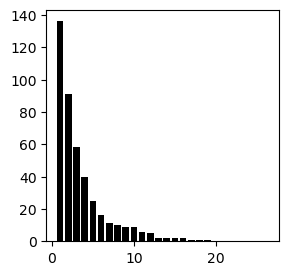

In [124]:
fig, ax = plt.subplots(figsize=(3,3))

# plt.ylim(-1,170)


all_ese = []
all_ese_std = []
all_ese75 = []
all_ese25 = []
all_ff = []

for L in range(1,27):
    num_events = np.sum((df['event_day'] == L)&(shoulder==False))
    ax.bar(L, num_events, color='k')

In [124]:
14*units('cm/s').to('km/day')

# 15*units('km/day').to('cm/s')

<Quantity(12.096, 'kilometer / day')>

In [71]:
wind_durations = []
ice_durations = []
pol_durations = []

for year in years:

    df_year = df[df.year==year]
    wind_dates = pd.to_datetime(df_year.time[wind_cond(df_year)].values)
    wind_seqs = tseries.dates_to_sequences(wind_dates, dt_max=1*units('day'))

    for ss in wind_seqs:
        
        wind_durations.append(len(wind_seqs[ss]))
         
    ice_dates = pd.to_datetime(df_year.time[ice_cond(df_year)].values)
    ice_seqs = tseries.dates_to_sequences(ice_dates, dt_max=1*units('day'))

    for ss in ice_seqs:
        
        ice_durations.append(len(ice_seqs[ss]))
        
    pol_dates = pd.to_datetime(df_year.time[df_year.extent>0].values)
    pol_seqs = tseries.dates_to_sequences(pol_dates, dt_max=1*units('day'))

    for ss in pol_seqs:
        
        pol_durations.append(len(pol_seqs[ss]))
        

In [677]:
wind_seqs

{}

Text(0, 0.5, 'Frequency (%)')

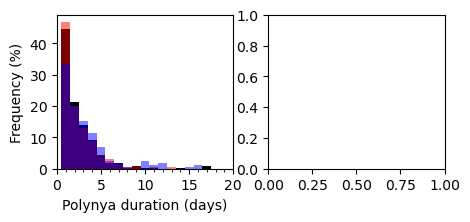

In [856]:
fig, axs = plt.subplots(1,2,figsize=(5,2))

bins = np.arange(0.5,30,1)
x = wind_durations
h = plotter.quick_hist(x, bin_edges = bins)
ax = axs[0]
ax.bar(h['centers'], 100*h['counts']/np.sum(h['counts']), align='center', width = np.diff(bins), 
       color='k')

x = ice_durations
h = plotter.quick_hist(x, bin_edges = bins)
ax = axs[0]
ax.bar(h['centers'], 100*h['counts']/np.sum(h['counts']), align='center', width = np.diff(bins), 
       color='r', alpha=0.5)


x = pol_durations
h = plotter.quick_hist(x, bin_edges = bins)
ax = axs[0]
ax.bar(h['centers'], 100*h['counts']/np.sum(h['counts']), align='center', width = np.diff(bins), 
       color='b', alpha=0.5)


# ax.set_xticks([1,5,10,15,20])
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_xlabel('Polynya duration (days)')
ax.set_xlim(0,20)
ax.set_ylabel('Frequency (%)')

In [105]:
# 20*units('km/day').to('cm/s')

11.6*units('cm/s').to('km/day')

<Quantity(10.0224, 'kilometer / day')>

In [364]:
yearss = np.arange(2003,2026)

-0.3638191927935925 0.1323644050449812
LinregressResult(slope=-0.05744192242524946, intercept=125.24303039972114, rvalue=-0.3638191927935925, pvalue=0.0960206595261915, stderr=0.03288493916042277, intercept_stderr=66.23363098719192)
0.45990042909220447 0.2115084046791938
LinregressResult(slope=0.01863860974511249, intercept=-36.74895874635517, rvalue=0.45990042909220447, pvalue=0.04132524528088272, stderr=0.008482267845058438, intercept_stderr=17.07531028726321)


Text(0.05, 0.7, 'slope=0.2')

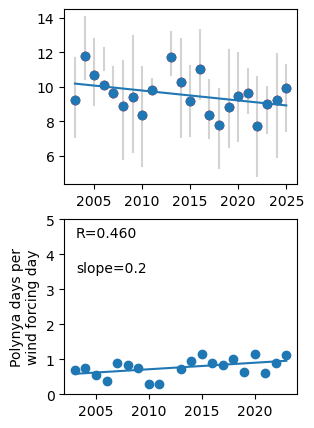

In [108]:
fig, axs = plt.subplots(2,1,figsize=(3,5))

all_ws = []


ax = axs[0]
for year in yearss[yearss!=2012]:
    
#     ax.scatter(year, np.nanpercentile(dfr.s10[(dfr.extent>0)&(dfr.year==year)&(dfr['final_day']==False)], 25), c='k', s=1)
#     ax.scatter(year, np.nanpercentile(dfr.s10[(dfr.extent>0)&(dfr.year==year)&(dfr['final_day']==False)], 50), c='k')
#     ax.scatter(year, np.nanpercentile(dfr.s10[(dfr.extent>0)&(dfr.year==year)&(dfr['final_day']==False)], 75), c='k', s=1)
    
    
    
    size_cond = (dfr.extent>0)&(dfr['final_day']==False)
    size_cond[(dfr['single_day']==True)] = True
    
    speeds = dfr.s10[size_cond&(dfr.year==year)]
    
    ax.scatter(year, np.nanmean(speeds), c='r')
    
    
    ax.plot([year,year], [np.nanpercentile(speeds, 25), np.nanpercentile(speeds, 75)], c='lightgray', zorder=-1)
    
    
#     all_ws.append(np.nanmean(dfr.s10[(dfr.extent>0)&(dfr.year==year)]))

    all_ws.append(np.nanmean(speeds))
    
    
x = yearss[yearss!=2012]
y = np.array(all_ws)


x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
res = stats.linregress(x_nn,y_nn)
R = res.rvalue
ax.scatter(x,y)
x_line = np.array([x_nn.min(), x_nn.max()])
y_line = res.intercept + res.slope*x_line
print(R, R**2)
print(res)
ax.plot(x_line, y_line)

ws_threshes = res.intercept + res.slope*np.arange(2003,2025)

ax = axs[1]

time_cond = ((yearss<2024)&(yearss!=2012))#&(yearss!=2016)

x = yearss[time_cond]
y = (all_pe/all_ie)[time_cond]


x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
res = stats.linregress(x_nn,y_nn)
R = res.rvalue
ax.scatter(x,y)
x_line = np.array([x_nn.min(), x_nn.max()])
y_line = res.intercept + res.slope*x_line
print(R, R**2)
print(res)
ax.plot(x_line, y_line)

ax.set_ylabel('Polynya days per\nwind forcing day')
ax.set_ylim(0,5)
ax.text(0.05,0.9, f'R={res.rvalue:.3f}', transform=ax.transAxes)
ax.text(0.05,0.7, f'slope={10*res.slope:.1f}', transform=ax.transAxes)

In [119]:
0.286*0.286

0.08179599999999998

In [ ]:
0.286*0.286

In [106]:
11.574074074/2

5.787037037

In [92]:
10 * units('km/day').to('cm/s')

<Quantity(11.5740741, 'centimeter / second')>

In [89]:
15 * units('cm/s').to('km/day')

<Quantity(12.96, 'kilometer / day')>

<BarContainer object of 22 artists>

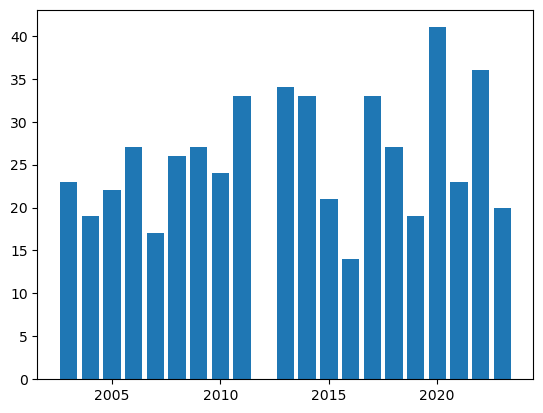

In [69]:
plt.bar(yearss[time_cond], per50_wf_numconsidered[time_cond])

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_9842/3577872852.py:57: RuntimeWarning: Mean of empty slice
  meant = np.sum(np.nanmean(dfr.t2m[yearr_cond]))


Text(2003.25, 87, '  Pack drift events (R=0.904)')

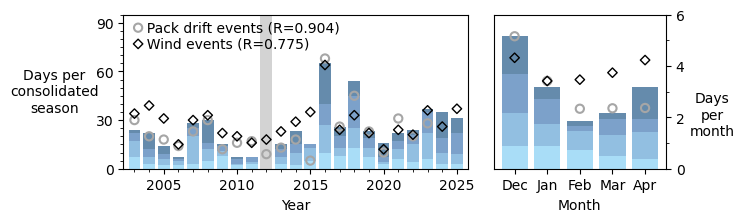

In [143]:
fig, axs = plt.subplots(1,2,figsize=(7,2), gridspec_kw={'width_ratios':[2,1]})

years = np.arange(2003,2026)
months = np.array([12,1,2,3,4])

# total events per year
annual_counts = [np.sum([pol_stats['counts'][month][year][0] for month in months]) for year in years]


mar1_kw = {'edgecolor': 'k', 'facecolor':'None', 'lw':1., 'marker':'D', 'zorder':10, 's':23}
mar2_kw = {'edgecolor': [0.65,0.65,0.65], 'facecolor':'None', 'lw':1.5, 'marker':'o', 's':35}


all_ie = []
all_pe = []
all_we = []
per50_wf = []
per50_wf_numconsidered = []
per25_wf = []
per75_wf = []
all_wf = []
all_nc = []
all_t2m = []

yearss = np.arange(2003,2026)

for yy, year in enumerate(yearss):
    
    month_colors = ['royalblue','skyblue','mediumpurple', 'lightcoral','r']
    
    yearr_cond = (dfr.year == year) 
#     yearr_cond = (dfr.year == year) & ([True if month in [12,1,2] else False for month in dfr.month])
#     yearr_cond = (dfr.year == year) & ([True if month in [3,4] else False for month in dfr.month])
    
    my_sizes = dfr['extent'][(dfr.extent>0)&(yearr_cond)].values
    
    num_events = len(dfr['extent'][((dfr.extent>0)&(yearr_cond))])
    all_pe.append(num_events)
    
    cts_by_size = {}
    for q, bnd in zip(['q1','q2','q3','q4'],
                      [(0,155), (155,545), (545,1715), (1715,100000)]):
        cts_by_size[q] = np.sum((my_sizes > bnd[0]) & (my_sizes <= bnd[1]))
        
   

    ax = axs[0]
    last_num = 0
    for color, q in zip([c1,c2,c3,c4],['q1','q2','q3','q4']):
        current_num = cts_by_size[q]       
        ax.bar(year, current_num, bottom = last_num, color=color, alpha=0.75)
        last_num+=current_num
        
    if year <= 2025:
        total_WE = np.sum(wind_cond(dfr[yearr_cond]))
        ax.scatter(year, total_WE, **mar1_kw)
        meant = np.sum(np.nanmean(dfr.t2m[yearr_cond]))
        all_we.append(total_WE)
        all_t2m.append(meant)
    else:
        all_we.append(np.nan)
        all_t2m.append(np.nan)
    
    if year <= 2023:
        total_IE = np.sum(ice_cond(dfr[yearr_cond]))
        ax.scatter(year, total_IE, **mar2_kw)
        all_ie.append(total_IE)
        
        WF = (dfr.si/dfr.s10)[(yearr_cond & (dfr.s10>3))&(wind_dir_cond(dfr))]
        
        all_nc.append(len(WF))
        
#         WF = (dfr.si/dfr.s10)[(yearr_cond & (dfr.s10>3))]
        
        all_wf.append(np.nanmean(WF))
        per50_wf.append(np.nanmedian(WF))
        per50_wf_numconsidered.append(len(WF))
        per25_wf.append(np.nanpercentile(WF, 25))
        per75_wf.append(np.nanpercentile(WF, 75))
    else:
        all_nc.append(np.nan)
        all_ie.append(np.nan)
        all_wf.append(np.nan)
        per50_wf.append(np.nan)
        per50_wf_numconsidered.append(np.nan)
        per25_wf.append(np.nan)
        per75_wf.append(np.nan)
        
ax.set_ylim(0,95)
ax.bar(2012, ax.get_xlim()[-1], color='lightgray', zorder=-11)
ax.set_xlim(2002.25,2025.75)
ax.set_ylabel('Days per\nconsolidated\nseason', rotation=0, labelpad=30, va='center')
ax.set_xlabel('Year')
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(30))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))


for mm, month in enumerate(months):

    monthb_cond = (dfb.month == month)#&(dfb.season_end_flag==False)
    my_sizes = dfb['extent'][(dfb.extent>0)&(monthb_cond)].values
#     days_per_year_ice = np.sum(monthb_cond)/len(years[:-2])
    days_per_year_ice = np.sum(monthb_cond)/len(list(set(dfb.year[monthb_cond])))
    
    cts_by_size = {}
    for q, bnd in zip(['q1','q2','q3','q4'],[(0,155), (155,545), (545,1715), (1715,100000)]):
        cts_by_size[q] = np.sum((my_sizes > bnd[0]) & (my_sizes <= bnd[1]))

    ax = axs[1]
    last_num = 0
    for color, q in zip([c1,c2,c3,c4],['q1','q2','q3','q4']):
        current_num = cts_by_size[q]/days_per_year_ice
        ax.bar(mm, current_num, bottom = last_num, color=color, alpha=0.75)
        last_num+=current_num
        
    total_WE = np.sum(wind_cond(dfb[(dfb.month==month)]))
    ax.scatter(mm, total_WE/days_per_year_ice, **mar1_kw)
    
    total_IE = np.sum(ice_cond(dfb[dfb.month==month]))
    ax.scatter(mm, total_IE/days_per_year_ice, **mar2_kw)
        

    
ax.set_ylabel('Days\nper\nmonth', rotation=0, labelpad=20, va='center')
ax.set_xlabel('Month')
ax.set_xticks(range(len(months)))
ax.set_xticklabels(['Dec','Jan','Feb','Mar','Apr'])
ax.set_ylim(0,6)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))


#     ax.scatter(year, cts_by_size['q1'])
#     ax.scatter(year, cts_by_size['q2'])
    
#     for mm, month in enumerate(months):
        
#         current_num = np.sum(pol_stats['counts'][month][year])            
#         ax.bar(year, current_num, bottom = last_num, color=month_colors[mm], alpha=0.75)
#         last_num += current_num


# plt.scatter(years, annual_counts, c='k')
        
# axs[0].set_ylim(2,18)


all_ie = np.array(all_ie)
all_pe = np.array(all_pe)
all_we = np.array(all_we)
all_t2m = np.array(all_t2m)
all_wf = np.array(all_wf)
per25_wf = np.array(per25_wf)
per50_wf = np.array(per50_wf)
per50_wf_numconsidered = np.array(per50_wf_numconsidered)
per75_wf = np.array(per75_wf)

plt.subplots_adjust(wspace=0.1)


x = all_ie[((yearss>=2003)&(yearss<2024))&(yearss!=2012)]
y = all_pe[((yearss>=2003)&(yearss<2024))&(yearss!=2012)]
x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
resp = stats.linregress(x_nn,y_nn)
Rp = resp.rvalue

x = all_we[((yearss>=2003)&(yearss<2024))&(yearss!=2012)]
y = all_pe[((yearss>=2003)&(yearss<2024))&(yearss!=2012)]
x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
resa = stats.linregress(x_nn,y_nn)
Rw = resa.rvalue


ax = axs[0]
ax.scatter(2003.25,77, **mar1_kw)
ax.text(2003.25,77, f'  Wind events (R={Rw:.3f})', va='center')
ax.scatter(2003.25,87, **mar2_kw)
ax.text(2003.25,87, f'  Pack drift events (R={Rp:.3f})', va='center')


# fig.savefig('../figures/results/occurence_stats.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [21]:
wind_cond

array([False, False, False, ..., False, False, False])

In [805]:
len(list(set(dfb.year[monthb_cond])))

11

In [800]:
years[:-2][10:]

array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

In [790]:
np.nanmean(dfr.s10[(df.extent>0)&(df.year>=2016)])

8.586905653149833

In [792]:
np.nanmean(dfr.s10[(df.extent>0)&(df.year<2005)])

9.451045320292847

0.9058458836221714 0.8205567648752325
LinregressResult(slope=0.9803326123390298, intercept=-5.857028262021746, rvalue=0.9058458836221714, pvalue=3.9077492529007874e-08, stderr=0.10805538819334855, intercept_stderr=3.556893863131427)


Text(0, 0.5, 'Polynya days per wind forcing')

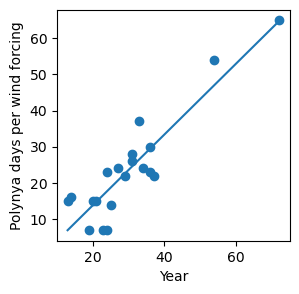

In [139]:
fig, ax = plt.subplots(figsize=(3,3))


time_cond = ((yearss<2024)&(yearss!=2012))#&(yearss!=2016)

x = all_ie[time_cond]
y = (all_pe)[time_cond]

# x = all_ie[time_cond]- y_line_i[time_cond]
# y = (all_pe)[time_cond]- y_line_p[time_cond]

# x = all_we[time_cond]- y_line_w[time_cond]
# y = (all_pe)[time_cond]- y_line_p[time_cond]

# x = all_we[time_cond]
# y = (all_pe)[time_cond]- y_line_p[time_cond]

# x = yearss[time_cond]
# y = (all_we)[time_cond] 


# x = all_wf[time_cond]
# y = (all_pe/all_we)[time_cond]


# x = all_we[time_cond]
# y = (all_pe)[time_cond]


x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
res = stats.linregress(x_nn,y_nn)
R = res.rvalue
ax.scatter(x,y)
x_line = np.array([x_nn.min(), x_nn.max()])
y_line = res.intercept + res.slope*x_line
print(R, R**2)
print(res)
ax.plot(x_line, y_line)


# y_line_i = res.intercept + res.slope*yearss

# y_line_p = res.intercept + res.slope*yearss
# y_line_w = res.intercept + res.slope*yearss

# ax.plot([0,80], [0,80], c='lightgray', zorder=-1)
# ax.set_xlim(0,80)
# ax.set_ylim(0,80)

ax.set_xlabel('Year')
ax.set_ylabel('Polynya days per wind forcing')


In [31]:
0.75*0.75

0.5625

a10_r
[260 265 270 275 280 285 290 295 300]
0.7961783439490446
[255 260 265 270 275 280 285 290 295]
0.8046709129511678
ai_r
[270 275 280 285 290 295 300 305 310]
0.7770700636942676
[260 265 270 275 280 285 290 295 300 305 310]
0.8386411889596603
centermass_direction_r
[290 295 300 305 310 315 320 325]
0.8222698072805139
[280 285 290 295 300 305 310 315 320 325]
0.9036402569593146


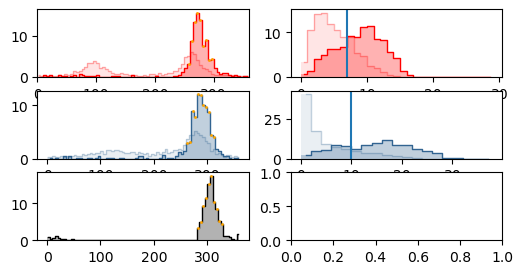

In [1866]:

# create plot
fig, AXS = plt.subplots(3,2, figsize=(6,3), subplot_kw={'projection': None})


#============
# DF = df[(df.year>=1987)&(df.year<2026)]
DF = dfb
# DF = df[(df.year>=2016)&(df.year<2024)]
# DF = df[(df.year>=2003)&(df.year<2016)]
#============

ccolor = c4
bcolor = 'red'

not_final_day = (DF.final_day == False)
not_final_day[DF.first_day==True] = True

bins = np.arange(0,361,5)
comp_ = (DF.extent==0)
# comp_ = (DF.extent>0)
open_ = (DF.extent>0)#&(not_final_day)
# open_strict = (DF.extent>0)&(DF.final_day == False)
# base_cond = (daily_data['ppd']['year'] >= 2003)&(daily_data['ppd']['year'] < 2024)


axs = AXS.ravel()

for ax, group, color in zip([axs[0], axs[2], axs[4]], 
                            ['a10_r', 'ai_r', 'centermass_direction_r'],
                            [bcolor, ccolor, 'k']):
    
#     x = DF[f'a{group}'][comp_]
#     x[x<0]+=360
#     h = plotter.quick_hist(x, bin_edges = bins)


    x = DF[f'{group}'][open_]
    h2 = plotter.quick_hist(x, bin_edges = bins)


    theta = h2['centers']
    width = h2['w']
    ax.bar(theta, 100*h2['prob'], width=width, bottom=0.0, alpha=0.3, color=color, zorder=-1)
    ax.step(theta, 100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=-1)

    
    if group != 'centermass_direction_r':
        x = DF[f'{group}'][comp_]
        h = plotter.quick_hist(x, bin_edges = bins)

        theta = h['centers']
        width = h['w']
        ax.bar(theta, 100*h['prob'], width=width, bottom=0.0, alpha=0.1, color=color, zorder=-1)
        ax.step(theta, 100*h['prob'], where='mid', alpha=0.3, color=color,lw=1, zorder=-1)

    # Plot bars
#     theta = h['centers']
#     width = h['w']
#     ax.bar(theta, 100*h['prob'], width=width, bottom=0.0, alpha=0.6, color=ccolor, zorder=0)
#     ax.step(theta, 100*h['prob'], where='mid', alpha=1, color=ccolor,lw=1, zorder=0)
    
    print(group)
#     ax.axvline((90-165)+360, c='k', ls='dashed')
#     ax.axvline((90-165-180)+360, c='k', ls='dashed')
    
    
    
    COND = (h2['prob']>1.25*h['prob'])&(h2['prob']>0.02)
    print(h2['edges'][:-1][COND])
    print(np.sum(h2['prob'][COND]))
#     print(h2['centers'][np.argmax(h2['prob'])])
    
    COND = (h2['prob']>0.025)
    print(h2['edges'][:-1][COND])
    print(np.sum(h2['prob'][COND]))
    
    ax.scatter(h2['centers'][COND], 100*h2['prob'][COND], s=1, c='orange')
    
#     ax.set_ylim(0,20)
    
#     ax.set_xlim(0,360)

    
ax = axs[0]
# ax.axvline((90-165)+360, c='k', ls='dashed')

ax.set_xlim(0,360)


for ax, group, color, bins in zip([axs[1], axs[3]], 
                            ['s10', 'si_km',],
                            [bcolor, ccolor], [np.arange(0,30,1), np.arange(0,40,2)]):
    
    
    x = DF[f'{group}'][open_]
    h2 = plotter.quick_hist(x, bin_edges = bins)


    theta = h2['centers']
    width = h2['w']
    ax.bar(theta, 100*h2['prob'], width=width, bottom=0.0, alpha=0.3, color=color, zorder=-1)
    ax.step(theta, 100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=-1)
    
    x = DF[f'{group}'][comp_]
    h = plotter.quick_hist(x, bin_edges = bins)

    theta = h['centers']
    width = h['w']
    ax.bar(theta, 100*h['prob'], width=width, bottom=0.0, alpha=0.1, color=color, zorder=-1)
    ax.step(theta, 100*h['prob'], where='mid', alpha=0.3, color=color,lw=1, zorder=-1)
    
ax = axs[1]
ax.axvline(7)

ax = axs[3]
ax.axvline(10)

10
260
270
280
290
300
310
320


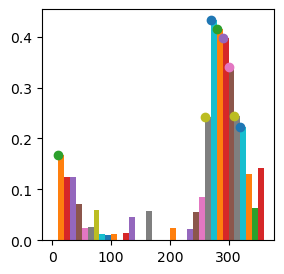

In [1867]:
fig, ax = plt.subplots(figsize=(3,3))

bins = np.arange(0,361,10)

not_final_day = (DF.final_day == False)
not_final_day[DF.first_day==True] = True

#===========
DF = dfb
#===========

var = 'a10_r'
# var = 'ai_r'

tot = 0
for bb in range(len(bins)-1):
    
    bbmin = bins[bb]
    bbmax = bins[bb+1]
    dbb = np.diff(bins)[0]
    bbmid = bbmin + dbb/2
    
#     within_range = ((DF[var] >= bbmin) & (DF[var] < bbmax)) & (DF['s10']>6.5)
    within_range = ((DF[var] >= bbmin) & (DF[var] < bbmax))# & (DF['si_km']>11.5)
    
#     frac = np.sum((DF.extent[within_range]>0)&(not_final_day[within_range]))/np.sum(within_range)
    frac = np.sum((DF.extent[within_range]>0))/np.sum(within_range)
    
    plt.bar(bbmin, frac, width = dbb, align='edge')
    
    if frac > 0.15:
        ax.scatter(bbmin, frac)
        print(bbmin)
        tot+=frac

In [ ]:
270-310

In [ ]:
270-340

In [ ]:
260-320

In [350]:
WITHIN = ((DF['a10_r'] > 260) & (DF['a10_r'] < 305))# & (DF['s10']>6.5)
np.sum(DF.extent[WITHIN]>0)/np.sum(DF.extent>0)

0.7961783439490446

In [351]:
WITHIN = (DF['ai_r'] > 270) & (DF['ai_r'] < 315) #& (DF['si_km']>11.5)
np.sum(DF.extent[WITHIN]>0)/np.sum(DF.extent>0)

0.7770700636942676

In [346]:
WITHIN = ((DF['a10_r'] > 260) & (DF['a10_r'] < 305)) & (DF['s10']>6.5)
np.sum(WITHIN&(DF.extent>0))/np.sum(WITHIN)

0.48822605965463106

In [348]:
WITHIN = ((DF['ai_r'] > 270) & (DF['ai_r'] < 315)) & (DF['si_km']>11.5)
np.sum(WITHIN&(DF.extent>0))/np.sum(WITHIN)

0.5100182149362478

In [582]:
tot

2.2938361994332017

In [590]:
260 - 330

-70

In [2378]:
305-260

45

In [2379]:
315-270

45

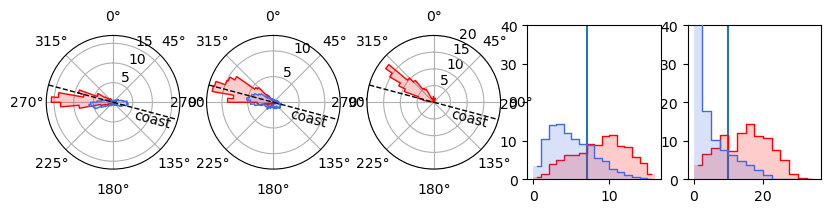

In [1632]:

# create plot
fig, AXS = plt.subplots(1,5, figsize=(10,2), subplot_kw={'projection': None})

axs = AXS.ravel()
# Override specific subplots to be polar using add_subplot
fig.delaxes(axs[0])
fig.delaxes(axs[1])
fig.delaxes(axs[2])
axs[0] = fig.add_subplot(1,5, 1, projection='polar')
axs[1] = fig.add_subplot(1,5, 2, projection='polar')
axs[2] = fig.add_subplot(1,5, 3, projection='polar')

for ax in [axs[0], axs[1], axs[2]]:
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid(zorder=-1)

#============
DF = dfb

# DF = df[(df.year>=2003)&(df.year<2016)]
# DF = df[(df.year>=2016)&(df.year<2026)]
#============

ccolor = c2
bcolor = 'red'

bins = np.arange(0,361,5)
comp_ = (DF.extent==0)
# open_ = (DF.extent>0)&(not_last_day)
open_ = (DF.extent>0)#&(not_last_day)

# open_ = DF.day_before_event == -1
# open_ = ((DF.extent>0)&(not_last_day)) + (DF.day_before_event == -1)
# open_strict = (open_)&(DF.final_day == False)
# base_cond = (daily_data['ppd']['year'] >= 2003)&(daily_data['ppd']['year'] < 2024)
#  'centermass_direction_r'
for ax, group, cond, color, scale in zip([axs[0], axs[0], ], 
                            ['a10_r', 'a10_r',], [open_ , comp_], 
                            ['r', 'royalblue', ], [1,1]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers'] * np.pi/180
    width = h2['w']* np.pi/180
    ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
    
    
    
    
for ax, group, cond, color, scale in zip([axs[1], axs[1], ], 
                            ['ai_r', 'ai_r',], [open_ , comp_], 
                            ['r', 'royalblue', ], [1,1]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers'] * np.pi/180
    width = h2['w']* np.pi/180
    ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
    
ax = axs[2]
x = DF[f'centermass_direction_r'][open_]
h2 = plotter.quick_hist(x, bin_edges = bins)
color = 'r'
scale = 1
theta = h2['centers'] * np.pi/180
width = h2['w']* np.pi/180
ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
    
    
    
    
axs[0].set_ylim(0,17)
axs[1].set_ylim(0,13)
axs[2].set_ylim(0,20)
for ax, R in zip([axs[0], axs[1], axs[2]], [5,3,5]):
    th = (90+15)*np.pi/180
    ax.plot([th, th], [0,ax.get_ylim()[1]], c='k', ls='dashed', lw=1, zorder=100)
    ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='k', ls='dashed', lw=1, zorder=100)
    ax.text((90+15)*np.pi/180, R, 'coast', rotation = -15, va='top')
    
    
    
    
# SPEEDS

bins = np.arange(0,17,1)
for ax, group, cond, color in zip([axs[3], axs[3], ], 
                            ['s10', 's10',], [open_ , comp_], 
                            ['r', 'royalblue', ]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)
    theta = h2['centers']
    width = h2['w']
    ax.bar(theta, 100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, 100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
ax.axvline(7) 
    
bins = np.arange(0,36,2.5)
for ax, group, cond, color in zip([axs[4], axs[4], ], 
                            ['si_km', 'si_km',], [open_ , comp_], 
                            ['r', 'royalblue', ]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)
    theta = h2['centers']
    width = h2['w']
    ax.bar(theta, 100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, 100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
ax.axvline(10) 

for ax in [axs[3], axs[4]]:
    ax.set_ylim(0,40)

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_35446/2857542963.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['N','','E','','S','','W '])
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_35446/2857542963.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['N','','E','','S','','W '])
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_35446/2857542963.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['N','','E','','S','','W '])


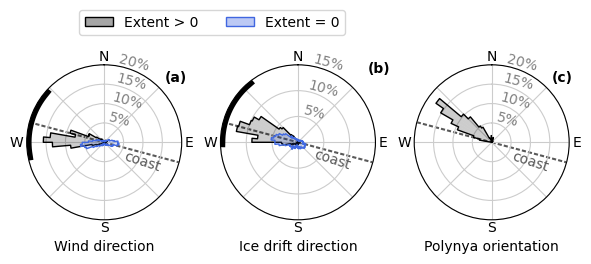

In [1445]:

# create plot
fig, axs = plt.subplots(1,3, figsize=(7,3), subplot_kw={'projection': 'polar'})

# axs = AXS.ravel()
# # Override specific subplots to be polar using add_subplot
# fig.delaxes(axs[0])
# fig.delaxes(axs[1])
# fig.delaxes(axs[2])
# axs[0] = fig.add_subplot(1,5, 1, projection='polar')
# axs[1] = fig.add_subplot(1,5, 2, projection='polar')
# axs[2] = fig.add_subplot(1,5, 3, projection='polar')

for ax in axs:
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid(zorder=-1)
    ax.set_xticklabels(['N','','E','','S','','W '])
    ax.grid(color=[0.8,0.8,0.8])
    ax.tick_params(axis='x', pad=-5)

#============
DF = dfb

# DF = df[(df.year>=2003)&(df.year<2016)]
# DF = df[(df.year>=2016)&(df.year<2026)]
#============

ccolor = c2
bcolor = 'red'

bins = np.arange(0,361,5)
comp_ = (DF.extent==0)
open_ = (DF.extent>0)

for ax, group, cond, color, scale in zip([axs[0], axs[0], ], 
                            ['a10_r', 'a10_r',], [open_ , comp_], 
                            ['k', 'royalblue', ], [1,1]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers'] * np.pi/180
    width = h2['w']* np.pi/180
    ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
    
    
    
    
for ax, group, cond, color, scale in zip([axs[1], axs[1], ], 
                            ['ai_r', 'ai_r',], [open_ , comp_], 
                            ['k', 'royalblue', ], [1,1]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers'] * np.pi/180
    width = h2['w']* np.pi/180
    ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
    
ax = axs[2]
x = DF[f'centermass_direction_r'][open_]
h2 = plotter.quick_hist(x, bin_edges = bins)
color = 'k'
scale = 1
theta = h2['centers'] * np.pi/180
width = h2['w']* np.pi/180
ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
    
    
    
ax = axs[0]
ax.set_ylim(0,20)
ax.set_yticks([5,10,15,20])

ax = axs[1]
ax.set_ylim(0,15)
ax.set_yticks([5,10,15])

ax = axs[2]
ax.set_ylim(0,20)
ax.set_yticks([5,10,15,20])

for ax in axs:
    ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()])
    ax.tick_params(axis='y', labelrotation=-15, colors='gray')
    ax.set_rlabel_position(10)
    
for ax, R in zip([axs[0], axs[1], axs[2]], [5,3,5]):
    th = (90+15)*np.pi/180
    ls_kw = {'c':[0.35,0.35,0.35], 'ls':'dashed', 'dashes':(2, 1), 'lw':1.5, 'zorder':-100}
    ax.plot([th, th], [0,ax.get_ylim()[1]], **ls_kw)
    ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], **ls_kw)
    ax.text((90+15+5)*np.pi/180, R, 'coast', color=[0.35,0.35,0.35], rotation = -18, va='top')
    
    
    
    
    


    
axs[0].text(np.pi/4, 22, '(a)', weight='bold', clip_on=False)
axs[1].text(np.pi/4, 19, '(b)', weight='bold', clip_on=False)
axs[2].text(np.pi/4, 22, '(c)', weight='bold', clip_on=False)


ax = axs[0]
th1 = 260*np.pi/180
th2 = 310*np.pi/180
ax.plot(np.linspace(th1,th2,20), np.full(20,ax.get_ylim()[1]), c=color, ls='solid', lw=7)
ax.set_xlabel('Wind direction') 

ax = axs[1]
th1 = 270*np.pi/180
th2 = 320*np.pi/180
ax.plot(np.linspace(th1,th2,20), np.full(20,ax.get_ylim()[1]), c=color, ls='solid', lw=7)
ax.set_xlabel('Ice drift direction') 
    
ax = axs[2]
# th1 = 290*np.pi/180
# th2 = 325*np.pi/180
# ax.plot(np.linspace(th1,th2,20), np.full(20,ax.get_ylim()[1]), c=color, ls='solid', lw=5)
ax.set_xlabel('Polynya orientation') 

patch1 = mpatches.Patch(edgecolor=(0,0,0,1), facecolor=(0,0,0,0.35),  label='Extent > 0')
patch2 = mpatches.Patch(edgecolor=(0.25,0.4,0.88,1), facecolor=(0.25,0.4,0.88,0.35),  label='Extent = 0')  
axs[0].legend(handles=[patch1, patch2], ncols=2, bbox_to_anchor=(2.1,1.4))

plt.subplots_adjust(wspace=0.25)

# fig.savefig('../figures/results/forcing_distributions.png', dpi=400, bbox_inches='tight')

In [2443]:
325-290

35

In [2286]:
[f'{tick:.0f}%' for tick in ax.get_yticks()]

['5%', '10%', '15%', '20%']

In [2284]:
[f'{tick:.0f}%' for tick in ax.get_yticks()]

['5%', '10%', '15%', '20%']

<>:128: SyntaxWarning: invalid escape sequence '\m'
<>:144: SyntaxWarning: invalid escape sequence '\m'
<>:128: SyntaxWarning: invalid escape sequence '\m'
<>:144: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/1699829080.py:128: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Wind\nspeed\n($\mathrm{m\;s^{-1}}$)', c=wind_color, rotation=0, labelpad=20, va='center')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/1699829080.py:144: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Ice drift\nspeed\n($\mathrm{km\;d^{-1}}$)', c=ice_color, rotation=0, labelpad=25, va='center')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/1699829080.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['N','','E','','S','','W ']);
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipyker

Text(37, 11, '35%')

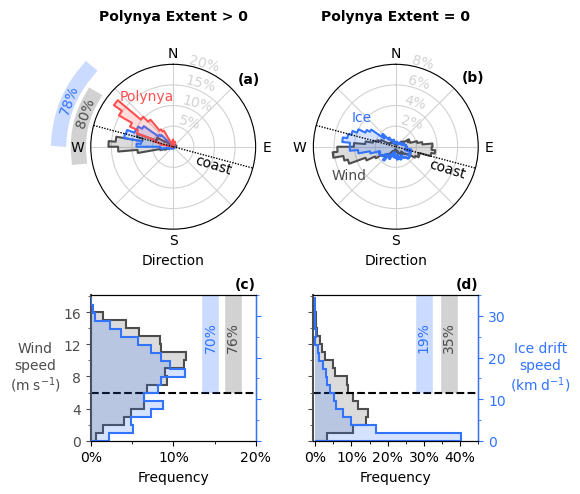

In [1915]:

# create plot
fig, AXS = plt.subplots(2,2, figsize=(5,5), subplot_kw={'projection': None}, gridspec_kw={'height_ratios':[1.25,1]})

axs = AXS.ravel()
# Override specific subplots to be polar using add_subplot
fig.delaxes(axs[0])
fig.delaxes(axs[1])
axs[0] = fig.add_subplot(2,2, 1, projection='polar')
axs[1] = fig.add_subplot(2,2, 2, projection='polar')


grid_color = [0.825,0.825,0.825]


for ax in axs[:2]:
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid(zorder=-1)
    ax.set_xticklabels(['N','','E','','S','','W ']);
    ax.grid(color=grid_color)
    ax.tick_params(axis='x', pad=-2.5)

#============
DF = dfb

# DF = df[(df.year>=2003)&(df.year<2016)]
# DF = df[(df.year>=2016)&(df.year<2026)]
#============

bins = np.arange(0,361,5)
comp_ = (DF.extent==0)
open_ = (DF.extent>0)

#============
# ice_color = [25/255,135/255,255/255]#'royalblue'
ice_color = [0.19607843137254902, 0.45098039215686275, 1.0]
# wind_color = 'r'
# wind_color = [255/255,135/255,0/255] # orange
# wind_color = [255/255,80/255,80/255]
wind_color = [0.3,0.3,0.3]
#============

for ax, group, cond, color, scale in zip([axs[0], axs[0], axs[0]], 
                            ['a10_r', 'ai_r', 'centermass_direction_r'], [open_ , open_, open_], 
                            [wind_color, ice_color, [255/255,80/255,80/255]], [1,1,1]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers'] * np.pi/180
    width = h2['w']* np.pi/180
    ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1.5, zorder=3)
    
    
for ax, group, cond, color, scale in zip([axs[1], axs[1]], 
                            ['a10_r', 'ai_r', ], [comp_ , comp_,], 
                            [wind_color, ice_color,], [1,1]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers'] * np.pi/180
    width = h2['w']* np.pi/180
    ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1.5, zorder=3)
    
      
    
axs[0].set_ylim(0,20)
axs[1].set_ylim(0,8)
axs[1].set_yticks([2,4,6,8])
for ax in axs[:2]:
    ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()])
#     ax.set_yticklabels([f'{tick:.0f}%' if tt%2==1 else '' for tt, tick in enumerate(ax.get_yticks())])
    ax.tick_params(axis='y', labelrotation=-15, colors=grid_color, pad=5)
    ax.set_rlabel_position(10)

for ax, R in zip([axs[0], axs[1]], [5,3.25,]):
    th = (90+15)*np.pi/180
    ax.plot([th, th], [0,ax.get_ylim()[1]], c='k', ls='dashed',dashes=(1,1), lw=1, zorder=100)
    ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='k', ls='dashed',dashes=(1,1), lw=1, zorder=100)
    ax.text((90+17)*np.pi/180, R, 'coast', rotation = -17, va='top')

    
# SPEED BINS
#_________________

bins = np.arange(0,17,1)
for ax, group, cond, color in zip([axs[2], axs[3], ], 
                            ['s10', 's10',], [open_ , comp_], 
                            [wind_color,wind_color, ]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)
    theta = h2['centers']
    width = h2['w']
    ax.barh(theta, 100*h2['prob'], height=width, left=0.0, alpha=0.2, color=color, zorder=-100)
    ax.stairs(100*h2['prob'], edges=h2['edges'],orientation='horizontal', alpha=1, color=color,lw=1.5, zorder=-100)



bins = np.arange(0,35,1.92)
ax2 = axs[2].twinx()
ax3 = axs[3].twinx()
for ax, group, cond, color in zip([ax2, ax3, ], 
                            ['si_km', 'si_km',], [open_ , comp_], 
                            [ice_color, ice_color, ]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)
    theta = h2['centers']
    width = h2['w']
    ax.barh(theta, 100*h2['prob'], height=width, left=0.0, alpha=0.2, color=color, zorder=-100)
    ax.stairs(100*h2['prob'], edges=h2['edges'], orientation='horizontal', alpha=1, color=color,lw=1.5, zorder=-100)



for ax in axs[2:]:
    ax.set_ylim(0,18.14)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(4))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))
    ax.spines['left'].set_color(wind_color)
    ax.spines['left'].set_linewidth(1.5)
    ax.tick_params(axis='y', which='both', color=wind_color, labelcolor=wind_color)
    
ax = axs[2]
ax.set_ylabel('Wind\nspeed\n($\mathrm{m\;s^{-1}}$)', c=wind_color, rotation=0, labelpad=20, va='center')
ax = axs[3]
ax.set_yticklabels([])


for ax in [ax2,ax3]:
    ax.set_ylim(0,35)
    ax.yaxis.tick_right()
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax.spines['right'].set_color(ice_color)
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_color('None')
    ax.tick_params(axis='y', which='both', color=ice_color, labelcolor=ice_color)
    
ax = ax3
ax.set_ylabel('Ice drift\nspeed\n($\mathrm{km\;d^{-1}}$)', c=ice_color, rotation=0, labelpad=25, va='center')
ax = ax2
ax.set_yticklabels([])
    
    
    
axs[2].set_xlim(-0.05,20)   
axs[3].set_xlim(-0.5,45)   
for ax in axs[2:]:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax.set_xlabel('Frequency')
    ax.set_xticklabels([f'{tick:.0f}%' for tick in ax.get_xticks()])

axs[0].text(0.5, 1.25, 'Polynya Extent > 0', weight='bold', ha='center', va='bottom', transform=axs[0].transAxes)
axs[1].text(0.5, 1.25, 'Polynya Extent = 0', weight='bold', ha='center', va='bottom', transform=axs[1].transAxes)

axs[0].text(np.pi/4, 22, '(a)', weight='bold', clip_on=False)
axs[1].text(np.pi/4, 9, '(b)', weight='bold', clip_on=False)

axs[2].text(1, 1.05, '(c)', weight='bold', ha='right', clip_on=False, transform=axs[2].transAxes)
axs[3].text(1, 1.05, '(d)', weight='bold', ha='right', clip_on=False, transform=axs[3].transAxes)

buffer = 4 # shorten because line too wide

ax = axs[0]
th1 = (270+buffer)*np.pi/180
th2 = (315-buffer)*np.pi/180
ax.plot(np.linspace(th1,th2,15), np.full(15,27.75), alpha=0.25, c=ice_color, ls='solid', lw=11, clip_on=False, zorder=-1000)
ax.text((285)*np.pi/180, 29, '78%', c=ice_color, rotation = 70, va='bottom')
th1 = (260+buffer)*np.pi/180
th2 = (305-buffer)*np.pi/180
ax.plot(np.linspace(th1,th2,15), np.full(15,23), alpha=0.25, c=wind_color, ls='solid', lw=11, clip_on=False, zorder=-1000)
ax.text((280)*np.pi/180, 24.5, '80%', c=wind_color, rotation = 70, va='bottom')
ax.set_xlabel('Direction') 
ax = axs[1]
ax.set_xlabel('Direction') 

for ax, xx,ll in zip(axs[2:], [14,23], ['73%', '31%']):
    ax.axhline(6,c='k', ls='dashed')
#     ax.axhline(6.5,c=ice_color, ls='dashed', dashes=(5,5))
    
# ax = axs[3]
# ax.text(25, 7.25, '$\mathrm{6.5\;m\;s^{-1}}$', c=wind_color, ha='center');
# ax.text(25, 4.25, '$\mathrm{10\;km\;d^{-1}}$', c=ice_color, ha='center');
    
    
axs[1].text(243*np.pi/180, 7, 'Wind', c=wind_color)
axs[1].text(300*np.pi/180, 5, 'Ice', c=ice_color)

axs[0].text(311*np.pi/180, 17.35, 'Polynya', c=[255/255,80/255,80/255])

plt.subplots_adjust(hspace=0.35, wspace=0.35)



ax = axs[2]
ax.plot([14.5,14.5],[7.1,30], alpha=0.25, c=ice_color, ls='solid', lw=12,)
ax.text(14.5, 11, '70%', c=ice_color, rotation = 90, va='bottom', ha='center')
ax.plot([17.25,17.25],[7.1,30], alpha=0.25, c=wind_color, ls='solid', lw=12,)
ax.text(17.25, 11, '76%', c=wind_color,rotation = 90, va='bottom', ha='center')


ax = axs[3]
ax.plot([30,30],[7.1,30], alpha=0.25, c=ice_color, ls='solid', lw=12,)
ax.text(30, 11, '19%', c=ice_color, rotation = 90, va='bottom', ha='center')
ax.plot([37,37],[7.1,30], alpha=0.25, c=wind_color, ls='solid', lw=12,)
ax.text(37, 11, '35%', c=wind_color,rotation = 90, va='bottom', ha='center')

# fig.savefig('../figures/results/forcing_distributions.png', dpi=400, bbox_inches='tight')

In [1923]:
cond = DF.extent==0

print('wind')
print(np.sum(dir_conds(DF[cond], 'wind'))/np.sum(cond))
print(np.sum(speed_conds(DF[cond], 'wind'))/np.sum(cond))

print('\nice')
print(np.sum(dir_conds(DF[cond], 'ice'))/np.sum(cond))
print(np.sum(speed_conds(DF[cond], 'ice'))/np.sum(cond))

wind
0.25930278104191146
0.3525264394829612

ice
0.3219741480611046
0.18527222875048963


In [1922]:
dir_event = dir_conds(DF, 'wind') & dir_conds(DF, 'ice')
speed_event = speed_conds(DF, 'wind') & speed_conds(DF, 'ice')

print(np.sum(cond&dir_event)/np.sum(dir_event))
print(np.sum(cond&(dir_event&speed_event))/np.sum(dir_event&speed_event))

0.4168765743073048
0.5775280898876405


In [1876]:
1/(6.5*units('m/s') / (10*units('km/day').to('m/s')))

<Quantity(0.0178062678, 'dimensionless')>

In [1854]:
np.sum(dir_conds(DF[cond], 'ice'))/np.sum(cond)

0.3219741480611046

In [1855]:
np.sum(dir_conds(DF[cond], 'ice')+dir_conds(DF[cond], 'wind'))/np.sum(cond)

0.40775558166862513

In [1851]:
np.nanpercentile(DF[cond][dir_conds(DF[cond], 'ice')+dir_conds(DF[cond], 'wind')].s10, 50)

9.695502569375368

In [1852]:
np.nanpercentile(DF[cond][dir_conds(DF[cond], 'ice')&dir_conds(DF[cond], 'wind')].si_km, 50)

16.734817261671825

In [1781]:
6 * (0.019290123456790122*100) * units('cm/s').to('km/day')

<Quantity(10.0, 'kilometer / day')>

In [1768]:
1*(0.0192901234*100)

1.92901234

In [1777]:
35 / (0.0192901234*100)

19.444444444444446

In [1764]:
10*units('km/day').to('m/s') / 6

<Quantity(0.0192901235, 'meter / second')>

In [1782]:
np.sum(speed_conds(DF[DF.extent>0], 'ice'))/np.sum(DF.extent>0)

0.7006369426751592

In [1783]:
np.sum(speed_conds(DF[DF.extent>0], 'wind'))/np.sum(DF.extent>0)

0.7622080679405521

In [813]:
np.sum(dir_conds(DF[DF.extent>0], 'ice'))/np.sum(DF.extent>0)

0.7770700636942676

In [812]:
np.sum(dir_conds(DF[DF.extent>0], 'wind'))/np.sum(DF.extent>0)

0.7961783439490446

In [702]:
0.0178 * 1 * units('m/s').to('km/day')

<Quantity(1.53792, 'kilometer / day')>

In [742]:
26*units('km/day').to('cm/s').to('m/s') * (1/0.0178)

<Quantity(16.9059509, 'meter / second')>

In [ ]:
30*units('km/day').to('cm/s').to('m/s') * (1/0.0178)

In [699]:
30.75*units('km/day').to('cm/s').to('m/s') * (1/0.0178)

<Quantity(19.9945381, 'meter / second')>

In [691]:
10*units('km/day').to('cm/s').to('m/s') * (1/0.0178)

<Quantity(6.50228881, 'meter / second')>

In [721]:
np.sum(speed_conds(DF[DF.extent==0], 'ice'))/np.sum(DF.extent==0)

0.18527222875048963

In [723]:
np.sum(speed_conds(DF[DF.extent>0], 'ice'))/np.sum(DF.extent>0)

0.7006369426751592

In [665]:
np.sum(speed_conds(DF[DF.extent>0], 'ice'))/np.sum(DF.extent>0)

0.7006369426751592

In [666]:
color1

[0.19607843137254902, 0.45098039215686275, 1.0]

In [168]:
0.02*20*units('m/s').to('cm/s').to('km/day')

<Quantity(34.56, 'kilometer / day')>

In [135]:
0.02*1*units('m/s').to('cm/s').to('km/day')

<Quantity(1.728, 'kilometer / day')>

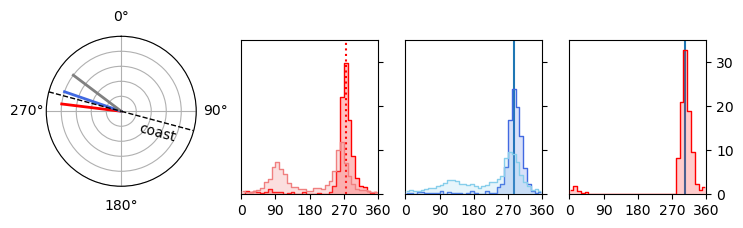

In [2371]:

# create plot
fig, AXS = plt.subplots(1,3, figsize=(6,2), subplot_kw={'projection': None})

axs = AXS.ravel()
# Override specific subplots to be polar using add_subplot
# fig.delaxes(axs[0])
# fig.delaxes(axs[1])
# fig.delaxes(axs[2])
# axs[0] = fig.add_subplot(1,5, 1, projection='polar')
# axs[1] = fig.add_subplot(1,5, 2, projection='polar')
# axs[2] = fig.add_subplot(1,5, 3, projection='polar')

# for ax in [axs[0]]:
#     ax.set_theta_zero_location("N")
#     ax.set_theta_direction(-1)
#     ax.grid(zorder=-1)






#============
DF = dfb

# DF = df[(df.year>=2003)&(df.year<2016)]
# DF = df[(df.year>=2016)&(df.year<2026)]
#============


for ax in [axs[0], axs[1]]:
    ax.set_xlim(0,360)

ccolor = c2
bcolor = 'red'

bins = np.arange(0,361,10)
comp_ = (DF.extent==0)
# open_ = (DF.extent>0)&(not_last_day)
open_ = (DF.extent>0)#&(not_last_day)

# open_ = DF.day_before_event == -1
# open_ = ((DF.extent>0)&(not_last_day)) + (DF.day_before_event == -1)
# open_strict = (open_)&(DF.final_day == False)
# base_cond = (daily_data['ppd']['year'] >= 2003)&(daily_data['ppd']['year'] < 2024)
#  'centermass_direction_r'
for ax, group, cond, color, alpha in zip([axs[0], axs[0], ], 
                            ['a10_r', 'a10_r',], [open_ , comp_], 
                            ['r', 'lightcoral', ], [1,1]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers']
    width = h2['w']
    ax.bar(theta, 100*h2['prob'], width=width, bottom=0.0, alpha=0.25, color=color, zorder=3)
    ax.step(theta, 100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
    
    
    
    
for ax, group, cond, color, scale in zip([axs[1], axs[1], ], 
                            ['ai_r', 'ai_r',], [open_ , comp_], 
                            ['royalblue', 'skyblue', ], [1,1]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers']
    width = h2['w']
    ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
    
for ax, group, cond, color, scale in zip([axs[2], ], 
                            ['centermass_direction_r', ], [open_ ], 
                            ['r', ], [1,]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers']
    width = h2['w']
    ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
    
for ax in axs:
    ax.set_xlim(0,360)
    ax.set_xticks([0,90,180,270,360])
    ax.set_ylim(0,35)
    ax.yaxis.tick_right()
    
for ax in axs[:-1]:
    ax.set_yticklabels([])

    
    
ax = axs[0]
ax.axvline((90-173)+360, c='r', ls='dotted')

ax = axs[1]
ax.axvline((90-165)+360)

ax = axs[2]
ax.axvline((90-145)+360)

# axs[0].set_ylim(0,20)
# axs[1].set_ylim(0,15)
# axs[2].set_ylim(0,20)
# for ax, R in zip([axs[0], axs[1], axs[2]], [5,3,5]):
#     th = (90+15)*np.pi/180
#     ax.plot([th, th], [0,ax.get_ylim()[1]], c='k', ls='dashed', lw=1, zorder=100)
#     ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='k', ls='dashed', lw=1, zorder=100)
#     ax.text((90+15)*np.pi/180, R, 'coast', rotation = -15, va='top')
    
    
AX = fig.add_axes([-0.45, 0.15, 0.75, 0.75], projection='polar') # inset polar axes
ax = AX
ax.set_ylim(0,10)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_yticklabels([])
ax.set_xticks(np.array([0,90,180,270])*(np.pi/180))


th = (90+15)*np.pi/180
ax.plot([th, th], [0,ax.get_ylim()[1]], c='k', ls='dashed', lw=1, zorder=100)
ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='k', ls='dashed', lw=1, zorder=100)
ax.text((90+15)*np.pi/180, 5, 'coast', rotation = -15, va='top', ha='center')

th = (90-173+360)*np.pi/180
ax.plot([th, th], [0,0.8*ax.get_ylim()[1]], c='r', ls='solid', lw=2, zorder=3)
# ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='r', ls='dashed', lw=1, zorder=100)
# ax.text((90+173)*np.pi/180, 0, 'coast', rotation = -15, va='top', ha='center')

th = (90-161+360)*np.pi/180
ax.plot([th, th], [0,0.8*ax.get_ylim()[1]], c='royalblue', ls='solid', lw=2, zorder=3)
# ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='royalblue', ls='dashed', lw=1, zorder=100)

th = (90-143+360)*np.pi/180
ax.plot([th, th], [0,0.8*ax.get_ylim()[1]], c='gray', ls='solid', lw=2, zorder=3)
# ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='gray', ls='dashed', lw=1, zorder=100)

In [2343]:
print(vectors.vector_angle(np.nanmean(DF['u10'][open_]), np.nanmean(DF['v10'][open_])))
print(vectors.vector_angle(np.nanmean(DF['ui'][open_]), np.nanmean(DF['vi'][open_])))
print(vectors.vector_angle(np.nanmean(DF['up'][open_]), np.nanmean(DF['vp'][open_])))

173.3737593024387 degree
161.75337988688685 degree
143.01459107603304 degree


In [1625]:
DF.up[COND]

2269   -38.204756
2278   -21.594618
2279   -16.129223
2290   -13.010949
2291   -25.661554
          ...    
5407     5.895805
5413     0.890385
5414   -30.744152
5415   -30.194390
5416   -17.019778
Name: up, Length: 471, dtype: float64

In [ ]:
df

In [353]:
DF = dfb

COND = DF.extent>0
A10 = vectors.vector_angle(np.nanmean(DF.u10[COND]), np.nanmean(DF.v10[COND]))
Ai = vectors.vector_angle(np.nanmean(DF.ui[COND]), np.nanmean(DF.vi[COND]))
Ap = vectors.vector_angle(np.nanmean(DF.up[COND]), np.nanmean(DF.vp[COND]))

print(A10)
print(Ai)
print(Ap)

173.3737593024387 degree
161.75337988688685 degree
143.01459107603304 degree


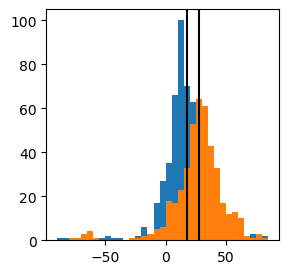

In [354]:
fig, ax = plt.subplots(figsize=(3,3))
plt.hist(DF['ta_wi'][open_], bins=np.arange(-90,90,5))
plt.hist(DF['ta_wp'][open_], bins=np.arange(-90,90,5))
plt.axvline(18, c='k')
plt.axvline(28, c='k')

In [2464]:
np.nanmedian(DF['ta_ip'][open_])

18.310160999317887

In [2463]:
np.nanmedian(DF['ta_wp'][open_])

28.500028176940397

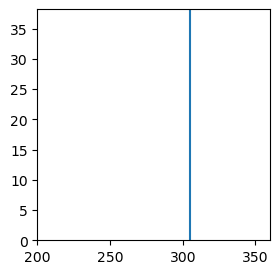

In [1422]:

#============
# DF = df[(df.year>=1987)&(df.year<2026)]
DF = dfb
# DF = df[(df.year>=2016)&(df.year<2024)]
# DF = df[(df.year>=2003)&(df.year<2016)]
#============

fig, ax = plt.subplots(figsize=(3,3))
x = DF[f'centermass_direction_r'][(DF.extent>0)]
h = plotter.quick_hist(x, bin_edges = bins)


theta = h['centers']
width = h['w']
ax.bar(theta, 100*h['prob'], width=width, bottom=0.0, alpha=0.1, color=color, zorder=-1)
ax.step(theta, 100*h['prob'], where='mid', alpha=0.3, color=color,lw=1, zorder=-1)
    

x = DF[f'max_length_direction_r'][(DF.extent>0)]
h = plotter.quick_hist(x, bin_edges = bins)


theta = h['centers']
width = h['w']
ax.bar(theta, 100*h['prob'], width=width, bottom=0.0, alpha=0.1, color='r', zorder=-1)
ax.step(theta, 100*h['prob'], where='mid', alpha=0.3, color='r',lw=1, zorder=-1)
    
    
ax.set_xlim(200,360)
ax.axvline((90-145)+360)

In [936]:
(90-165)+360

285

In [937]:
(90-145)+360

305

In [938]:
np.nanmedian(DF[f'max_length_direction_r'][(DF.extent>0)])

301.52934204516964

In [939]:
np.nanmedian(DF[f'centermass_direction_r'][(DF.extent>0)])

305.7704628259503

In [1203]:
10*units('km/day').to('m/s')/0.02

<Quantity(5.78703704, 'meter / second')>

In [1204]:
np.linspace(8,6, len(years))

array([8.        , 7.90909091, 7.81818182, 7.72727273, 7.63636364,
       7.54545455, 7.45454545, 7.36363636, 7.27272727, 7.18181818,
       7.09090909, 7.        , 6.90909091, 6.81818182, 6.72727273,
       6.63636364, 6.54545455, 6.45454545, 6.36363636, 6.27272727,
       6.18181818, 6.09090909, 6.        ])

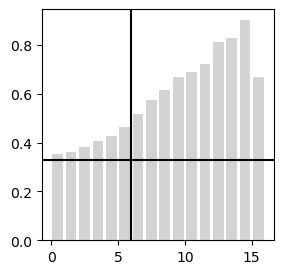

In [1274]:

# likelihoods = np.array([])

fig, ax = plt.subplots(figsize=(3,3))

# all_wind_dir = np.sum(wind_dir_cond)
# all_ice_dir = np.sum(ice_dir_cond)

cat = 'wind'
scat = 's10'

# cat = 'ice'
# scat = 'si_km'

all_dir = np.sum(dir_conds(DF, cat))

for bb in range(len(speed_bins[cat])-1):
    
    bmin = speed_bins[cat][bb]
    bmax = speed_bins[cat][bb+1]
    bmid = (bmax+bmin)/2
    
    not_last_day = (DF.final_day == False)
    not_last_day[DF.single_day == True] = True

    speed_range = (DF[scat] > bmin) & (DF[scat] > bmax)
#     speed_range = (DF[scat] < bmax)


    COND = speed_range & (dir_conds(DF, cat)==True)
    total_counts = np.sum(COND)
    open_counts = np.sum((DF['extent'][COND].values > 0))#&not_last_day[COND])
#     db_counts = np.sum(DF['day_before_event'][COND].values == -1)
    
#     plt.bar(bmid, (db_counts+open_counts)/total_counts, color='gray', width = 0.8*(bmax-bmin))
    plt.bar(bmid, (open_counts)/total_counts, color='lightgray', width = 0.8*(bmax-bmin))
    
    
#     plt.bar(bmid, 10*(total_counts/all_dir), bottom = 1, color='k', alpha=0.1, width = 0.8*(bmax-bmin))
    
plt.axvline(6, c='k')
plt.axhline(0.33, c='k')

In [1690]:
0.02 * 6 * units('m/s').to('km/day')

<Quantity(10.368, 'kilometer / day')>

In [1206]:

np.nanpercentile(DF.si[(DF['extent'] == 0)], 75)

9.048566991439179

In [1207]:
np.nanpercentile(DF.si[(DF['extent'] > 0)], 30)

11.697253499171095

In [1208]:
np.nanpercentile(DF.s10[(DF['extent'] > 0)], 30)

6.952249333466214

In [1975]:
years = np.arange(2003,2026)

#================
DF = dfr
#================


months = [12,1,2,3,4]
monthly = {}
monthly['pol_cts_no12'] = {}
monthly['pol_cts_no122425'] = {}
monthly['win_cts'] = {}
monthly['win_cts_no12'] = {}
monthly['win_cts_no2425'] = {}
monthly['win_cts_no122425'] = {}
monthly['ice_cts_no2425'] = {}
monthly['ice_cts_no122425'] = {}
monthly['tot_cts'] = {}
monthly['tot_cts_no12'] = {}
monthly['tot_cts_no2425'] = {}
monthly['tot_cts_no122425'] = {}

for key in monthly:
    for month in months:
        monthly[key][month] = 0

        
years = np.arange(2003,2026)
annual = {}
annual['pol_cts'] = {}
annual['win_cts'] = {}
annual['ice_cts'] = {}

for key in annual:
    for year in years:
        annual[key][year] = 0



pol_counts = np.array([])
win_counts = np.array([])
ice_counts = np.array([])

wind_factors = {}
wind_factors[25] = np.array([])
wind_factors[50] = np.array([])
wind_factors[75] = np.array([])

wf_match_years = np.array([])
years_match_wf = np.array([])

wind_speeds = {}
wind_speeds[25] = np.array([])
wind_speeds[50] = np.array([])
wind_speeds[75] = np.array([])

ice_speeds = {}
ice_speeds[25] = np.array([])
ice_speeds[50] = np.array([])
ice_speeds[75] = np.array([])

air_temps = {}
air_temps[25] = np.array([])
air_temps[50] = np.array([])
air_temps[75] = np.array([])

for year in years:
    
    
    year_cond = (DF.year == year)
    
    
    
    # EVENT COUNTS
    #------------------------------
    
    # polynyas
    #----------
    
    pol_cond = (DF.extent > 0)
    
    if year in [2012]:
        annual['pol_cts'][year] += np.nan
        pol_counts= np.append(pol_counts, np.nan)
    
    else:
        num_pol = np.sum(pol_cond&year_cond)
        annual['pol_cts'][year] += num_pol
        
        pol_counts= np.append(pol_counts, num_pol)

    # save monthly counts
    for month in months:
        month_cond = (DF.month == month)
        
        if year not in [2012]:
            monthly['pol_cts_no12'][month] += np.sum((year_cond&month_cond)&pol_cond)
            monthly['tot_cts_no12'][month] += np.sum(year_cond&month_cond)

        if year not in [2024,2025]: 
            monthly['pol_cts_no122425'][month] += np.sum((year_cond&month_cond)&pol_cond)
            monthly['tot_cts_no122425'][month] += np.sum(year_cond&month_cond)
    
    # winds
    #----------
    
    wind_cond = (dir_conds(DF, 'wind'))&(DF['s10'] > 6)
    num_win = len(DF[year_cond&wind_cond])
    win_counts= np.append(win_counts, num_win)
    
    
    annual['win_cts'][year] += np.sum(year_cond&wind_cond)
    
#     if year in [2012]:
#         annual['win_cts_no12'][year] += np.nan
#     else:
#         annual['win_cts_no12'][year] += np.sum(year_cond&wind_cond)
#         if year in [2024, 2025]:
#             annual['win_cts_no122425'][year] += np.nan
#         else:
#             annual['win_cts_no122425'][year] += np.sum(year_cond&wind_cond)
        
        
    for month in months:
        
        month_cond = (DF.month == month)
        monthly['win_cts'][month] += np.sum((year_cond&month_cond)&wind_cond)
        monthly['tot_cts'][month] += np.sum(year_cond&month_cond)

        if year not in [2012]:
            monthly['win_cts_no12'][month] += np.sum((year_cond&month_cond)&wind_cond)
        if year not in [2024, 2025]:
            monthly['tot_cts_no2425'][month] += np.sum((year_cond&month_cond))
            monthly['win_cts_no2425'][month] += np.sum((year_cond&month_cond)&wind_cond)
        if year not in [2012, 2024,2025]: 
            monthly['win_cts_no122425'][month] += np.sum((year_cond&month_cond)&wind_cond)

    # ice
    #----------
    
    ice_cond = (dir_conds(DF, 'ice'))&(DF['si_km'] > 10)
    
    annual['ice_cts'][year] += np.sum(year_cond&ice_cond)
    
    for month in months:
        
        month_cond = (DF.month == month)
        if year not in [2024,2025]:
            monthly['ice_cts_no2425'][month] += np.sum((year_cond&month_cond)&ice_cond)
        if year not in [2012, 2024, 2025]:
            monthly['ice_cts_no122425'][month] += np.sum((year_cond&month_cond)&ice_cond)
                
                
    
    if year > 2023:
        ice_counts= np.append(ice_counts, np.nan)
    else:
        num_ice = len(DF[(DF.year == year)&((dir_conds(DF, 'ice'))&(DF['si_km'] > 8.5))])
        ice_counts= np.append(ice_counts, num_ice)
    
#     wind_dir_cond
    all_ws = DF.s10[(DF.year == year)&(DF.extent>0)]
    for key in ice_speeds.keys():
        wind_speeds[key] = np.append(wind_speeds[key], np.nanpercentile(all_ws, key))
        
        
    all_t2m = DF.t2m[(DF.year == year)&(DF.extent>0)]
    for key in ice_speeds.keys():
        air_temps[key] = np.append(air_temps[key], np.nanpercentile(all_t2m, key))
            
    # ice speeds
    if year > 2023:
        for key in ice_speeds.keys():
            ice_speeds[key] = np.append(ice_speeds[key],  np.nan)
    else:
        all_is = DF.si[(DF.year == year)&(DF.extent>0)]
        for key in ice_speeds.keys():
            ice_speeds[key] = np.append(ice_speeds[key], np.nanpercentile(all_is, key))

    # wind factors
    if year > 2023:
        for key in wind_factors.keys():
            wind_factors[key] = np.append(wind_factors[key],  np.nan)
    else:
        all_wf = (DF.si/DF.s10)[((DF.year == year)&(dir_conds(DF, 'wind')))&(DF['s10']>3)]
        
        wf_match_years = np.append(wf_match_years, all_wf)
        years_match_wf = np.append(years_match_wf, np.full(len(all_wf), year))
        
        for key in ice_speeds.keys():
            wind_factors[key] = np.append(wind_factors[key], np.nanpercentile(all_wf, key))


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [1982]:
annual['pol_cts']

{2003: 23,
 2004: 22,
 2005: 14,
 2006: 7,
 2007: 28,
 2008: 30,
 2009: 15,
 2010: 8,
 2011: 7,
 2012: nan,
 2013: 15,
 2014: 23,
 2015: 15,
 2016: 65,
 2017: 24,
 2018: 53,
 2019: 23,
 2020: 16,
 2021: 21,
 2022: 25,
 2023: 37,
 2024: 35,
 2025: 31}

In [1976]:
annual['win_cts_no12'] = annual['win_cts'].copy()
annual['win_cts_no12'][2012] = np.nan

annual['win_cts_no2425'] = annual['win_cts'].copy()
annual['win_cts_no2425'][2024] = np.nan
annual['win_cts_no2425'][2025] = np.nan

annual['win_cts_no122425'] = annual['win_cts'].copy()
annual['win_cts_no122425'][2012] = np.nan
annual['win_cts_no122425'][2024] = np.nan
annual['win_cts_no122425'][2025] = np.nan

annual['ice_cts_no12'] = annual['ice_cts'].copy()
annual['ice_cts_no12'][2012] = np.nan

annual['ice_cts_no2425'] = annual['ice_cts'].copy()
annual['ice_cts_no2425'][2024] = np.nan
annual['ice_cts_no2425'][2025] = np.nan

annual['ice_cts_no122425'] = annual['ice_cts'].copy()
annual['ice_cts_no122425'][2012] = np.nan
annual['ice_cts_no122425'][2024] = np.nan
annual['ice_cts_no122425'][2025] = np.nan




In [1983]:
all_ice_cts = np.array([annual['ice_cts_no2425'][key] for key in annual['ice_cts_no2425'].keys()])
all_pol_cts = np.array([annual['pol_cts'][key] for key in annual['pol_cts'].keys()])
# all_win_cts = np.array([annual['win_cts_no122425'][key] for key in annual['win_cts_no122425'].keys()])
all_win_cts = np.array([annual['win_cts'][key] for key in annual['win_cts'].keys()])

years_no12 = np.append(np.arange(2003,2012), np.arange(2013,2026))
years_no122425 = np.append(np.arange(2003,2012), np.arange(2013,2024))

In [1986]:
len(all_pol_cts)

23

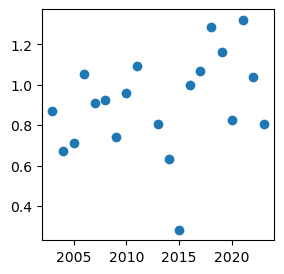

In [1978]:
fig, ax = plt.subplots(figsize=(3,3))
plt.scatter(years, all_ice_cts/all_win_cts)
# plt.scatter(years, all_pol_cts/all_win_cts)

In [1948]:
annual['ice_cts'][2012]

15

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Text(0.05, 1.05, 'Seasonal')

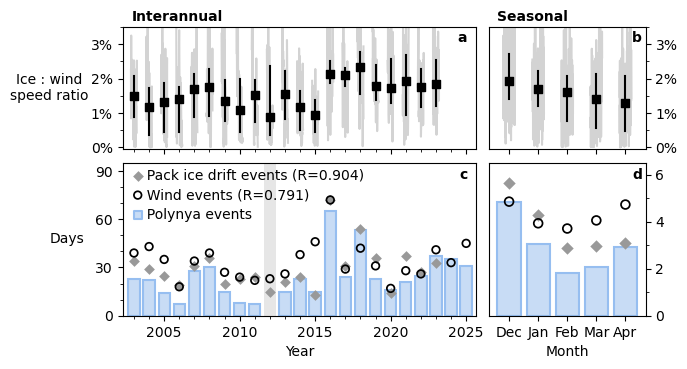

In [1949]:
fig, AXS = plt.subplots(2,2,figsize=(6.75,3.75), gridspec_kw={'width_ratios':[2.25,1], 'height_ratios':[1,1.25]})

axs = AXS.ravel()

years = np.arange(2003,2026)
months = [12,1,2,3,4]

# total events per year
# annual_counts = [np.sum([pol_stats['counts'][month][year][0] for month in months]) for year in years]


# mar1_kw = {'edgecolor': 'k', 'facecolor':'None', 'lw':1.25, 'marker':'P', 'zorder':10, 's':23}
# mar1_kw = {'edgecolor': 'k', 'facecolor':'k', 'lw':1, 'marker':'D', 'zorder':10, 's':30}
# mar2_kw = {'edgecolor': [0.35,0.35,0.35], 'facecolor':'lightgray', 'lw':1.5, 'marker':'o', 's':35}

C = [0.6,0.6,0.6]

mar1_kw = {'edgecolor': 'k', 'facecolor':'None', 'lw':1.25, 'marker':'o', 'zorder':10, 's':30}
mar2_kw = {'edgecolor': C, 'facecolor':C, 'lw':0, 'marker':'D', 's':30}

mar1_kw_L = {'edgecolor': 'k', 'facecolor':'None', 'lw':1.25, 'marker':'o', 'zorder':10, 's':40}
mar2_kw_L = {'edgecolor': C, 'facecolor':C, 'lw':0, 'marker':'D', 's':40}

# mar2_kw = {'edgecolor': 'None', 'facecolor':[0.65,0.65,0.65], 'lw':1.5, 'marker':'x', 's':30}

mar3_kw = {'facecolor':[200/255,220/255,245/255],'edgecolor':[150/255,190/255,240/255], 
           'lw':1.5, 'marker':'s', 's':40}
# bar_kw = {'facecolor':[166/255,205/255,255/255],'edgecolor':[130/255,175/255,235/255], 'lw':0, "alpha":1}

# bar_kw = {'facecolor':[220/255,230/255,247/255],'edgecolor':[130/255,175/255,235/255], 'lw':1.5, "alpha":1}
bar_kw = {'facecolor':[200/255,220/255,245/255],'edgecolor':[150/255,190/255,240/255], 'lw':1.5, "alpha":1}
# bar_kw = {'color':'lightcoral', "alpha":1}

ax = axs[2]

for yy, year in enumerate(years):
    year
    
    ax.bar(year, annual['pol_cts'][year], width=0.75, **bar_kw)
    ax.scatter(year, annual['win_cts'][year], **mar1_kw)
    
    
    ax.scatter(year, annual['ice_cts_no2425'][year], **mar2_kw)


        
ax.set_ylim(0,95)
ax.bar(2012, ax.get_xlim()[-1], color=[0.9,0.9,0.9], zorder=-11)
ax.set_xlim(2002.25,2025.75)
ax.set_ylabel('Days', rotation=0, labelpad=20, va='center')
ax.set_xlabel('Year')
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(30))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))

ax = axs[3]

for mm, month in enumerate(months):
    month
#     monthly['pol_cts'] = {}
# monthly['win_cts'] = {}
# monthly['ice_cts'] = {}
# monthly['tot_cts'] = {}
# monthly['tot_cts_no12'] = {}

#     ax.bar(mm, monthly['pol_cts_no12'][month]/monthly['tot_cts_no12'][month], alpha=0.5, color='b')


    total_days = monthly['tot_cts_no122425'][month]
    
    ax.bar(mm, len(years_no122425)*monthly['pol_cts_no122425'][month]/total_days, **bar_kw)
    ax.scatter(mm, len(years_no122425)*monthly['win_cts_no122425'][month]/total_days, **mar1_kw_L)
    ax.scatter(mm, len(years_no122425)*monthly['ice_cts_no122425'][month]/total_days, **mar2_kw_L)

# ax.set_ylabel('Days\nper\nmonth', rotation=0, labelpad=20, va='center')
ax.set_xlabel('Month')
ax.set_xticks(range(len(months)))
ax.set_xticklabels(['Dec','Jan','Feb','Mar','Apr'])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_ylim(0,6.5)

plt.subplots_adjust(wspace=0.1)


x = all_ice_cts
y = all_pol_cts
x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
resp = stats.linregress(x_nn,y_nn)
Rp = resp.rvalue

x = all_win_cts
y = all_pol_cts
x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
resa = stats.linregress(x_nn,y_nn)
Rw = resa.rvalue


ax = axs[2]
ax.scatter(2003.25,75, **mar1_kw)
ax.text(2003.25,75, f'  Wind events (R={Rw:.3f})', va='center')
ax.scatter(2003.25,87, **mar2_kw)
ax.text(2003.25,87, f'  Pack ice drift events (R={Rp:.3f})', va='center')
ax.scatter(2003.25,62.5, **mar3_kw)
ax.text(2003.25,62.5, f'  Polynya events', va='center')



ax = axs[0]
DF = dfb
for year in years:
    all_wf = (DF.si/DF.s10)[((DF.year == year)&(dir_conds(DF, 'wind')))&(DF['s10']>3)]
#     ax.scatter(year, np.nanmedian(all_wf), marker='*', c='k')
    
    bf = 0.2
    ax.plot(np.linspace(year-bf, year+bf,len(all_wf)), all_wf, c='lightgray',  zorder=-1)
#     ax.scatter(np.linspace(year-bf, year+bf,len(all_wf)), all_wf, c='lightgray', s=5, zorder=-1)
    ax.scatter(year, np.nanmedian(all_wf), marker='s', c='k')
    ax.plot([year,year], [np.nanpercentile(all_wf,25), np.nanpercentile(all_wf,75)], c='k')
#     print(year, np.nanmedian(all_wf))
    

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_xticklabels([])
ax.set_ylabel('Ice : wind\nspeed ratio', rotation=0, labelpad=30, va='center')
    
ax = axs[1]
# ax.set_ylim(-0.1,4.5)
DF = df[((df.year>=2003)&(df.year<=2023))&(df.year!=2012)]
for mm, month in enumerate(months):
    
    all_wf = (DF.si/DF.s10)[((DF.month == month)&(dir_conds(DF, 'wind')))&(DF['s10']>3)]
#     ax.scatter(year, np.nanmedian(all_wf), marker='*', c='k')
    bf = 0.2
    ax.plot(np.linspace(mm-bf, mm+bf,len(all_wf)), all_wf, c='lightgray', zorder=-1)
    ax.scatter(mm, np.nanmedian(all_wf), marker='s', c='k')
    ax.plot([mm,mm], [np.nanpercentile(all_wf,25), np.nanpercentile(all_wf,75)], c='k')
    
ax.set_xticks(range(len(months)))
ax.set_xticklabels([])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")


# ax.text(0.95, 1.05, 'Years\n2003-2011,\n2013-2023', 
#         weight='bold', size=9,
#         ha='right', va='bottom', clip_on=False, transform=ax.transAxes)

# ax.scatter(years, wind_factors[50])

for ax in axs[:-2]:
    ax.set_ylim(-0.1,5)
for ax in AXS[:,1]:
    ax.set_xlim(-0.7,4.7)
for ax in AXS[:,0]:
    ax.set_xlim(2002.25,2025.65)
    
def percent_format(x, pos):
    return f"{x:.0f}%" # Formats as percentage with 0 decimal places

for ax in AXS[0,:]:   
    ax.set_ylim(-0.05,3.5)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(percent_format))

plt.subplots_adjust(hspace=0.1, wspace=0.05)

for aa, ax in enumerate(axs):
    ax.text(0.975, 0.965, f'{chr(97+aa)}', weight='bold', ha='right', va='top', transform=ax.transAxes)

axs[0].text(0.025,1.05, 'Interannual', weight='bold', clip_on=False, transform = axs[0].transAxes)
axs[1].text(0.05,1.05, 'Seasonal', weight='bold', clip_on=False, transform = axs[1].transAxes)


# fig.savefig('../figures/results/occurrence_stats.png', dpi=400, bbox_inches='tight', pad_inches=0)


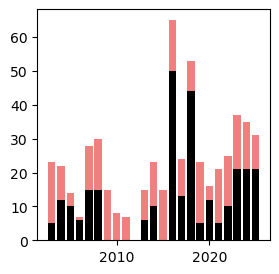

In [2013]:
fig, ax = plt.subplots(figsize=(3,3))

for YEAR in years:
    
    long_days = np.sum(df[df.year==YEAR].event_length >4)
    short_days = np.sum((df[df.year==YEAR].event_length <=4)&(df[df.year==YEAR].event_length >0))
    
    ax.bar(YEAR, long_days, color='k')
    ax.bar(YEAR, short_days, color='lightcoral', bottom = long_days)

In [1950]:
0.794**2

0.6304360000000001

In [1890]:
0.904 **2

0.817216

In [1738]:
0.01 * 6.5 * units('m/s').to('km/day')

<Quantity(5.616, 'kilometer / day')>

In [1215]:
np.sqrt(0.817)

0.9038805230781334

In [1216]:
np.sqrt(0.631)

0.79435508432942

In [1121]:
11*units('km/day').to('cm/s')

<Quantity(12.7314815, 'centimeter / second')>

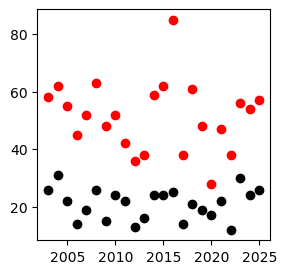

In [1951]:
ax = axs[0]
ax.set_ylim(-0.1,4)
DF = dfr

fig, ax = plt.subplots(figsize=(3,3))
for year in years:
    
    e_events = (DF.year == year)&(dir_conds(DF, 'wind'))
    
    
    month_cond = (DF.month==12)+(DF.month==1)
                
    ax.scatter(year, np.sum(month_cond&e_events), c='k')
                                       
        

    ax.scatter(year, np.sum(e_events), c='r')
                                    
#     all_wf = (DF.si/DF.s10)[((DF.year == year)&(dir_conds(DF, 'wind')))&(DF['s10']>3)]
# #     ax.scatter(year, np.nanmedian(all_wf), marker='*', c='k')
    
#     bf = 0.25
#     ax.plot(np.linspace(year-bf, year+bf,len(all_wf)), all_wf, c='lightgray',  zorder=-1)
#     ax.scatter(year, np.nanmedian(all_wf), marker='o', c='k')
#     ax.plot([year,year], [np.nanpercentile(all_wf,25), np.nanpercentile(all_wf,75)], c='k')
    

In [970]:
years

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024,
       2025])

In [821]:
monthly['tot_cts_no122425']

{12: 620, 1: 620, 2: 564, 3: 620, 4: 600}

In [822]:
years_no12 = np.append(np.arange(2003,2012), np.arange(2013,2026))
years_no122425 = np.append(np.arange(2003,2012), np.arange(2013,2024))

In [823]:
years_no122425

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

In [760]:
np.sqrt(np.nanmean((pol_counts - win_counts)**2))

11.46516463030514

In [1998]:
wind_factor_detrend

array([ 0.25541378, -0.10154547,  0.0011509 ,  0.0521051 ,  0.31648415,
        0.33934438, -0.08303038, -0.39780574,  0.01884853, -0.6673423 ,
       -0.00696572, -0.42980925, -0.69121368,  0.48168848,  0.39318077,
        0.59492383,  0.01720531, -0.06902573,  0.09910358, -0.08866834,
       -0.03404221,         nan,         nan])

0.7846033482264807 0.6156024140482041
LinregressResult(slope=1.193275424767596, intercept=0.027317241240894255, rvalue=0.7846033482264807, pvalue=4.206613113744199e-05, stderr=0.22225145491698528, intercept_stderr=0.044625200528653326)


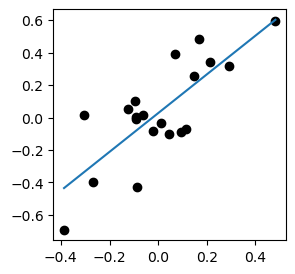

In [1999]:

    
# plt.bar(years, pol_counts)
# plt.scatter(years, win_counts)

fig, ax = plt.subplots(figsize=(3,3))
# x = years#[(years!=2016)&(years!=2018)]
# y = ice_speeds[25]/wind_factors[50]
# y = (all_pol_cts/all_win_cts)
# y = wind_factor_detrend[:-2][(years[:-2]!=2012)]
# y = wind_speeds[75]

# x = wind_factor_detrend
# y = pol_counts_perwind_detrend

x = pol_counts_perwind_detrend
y = wind_factor_detrend

# y = wind_factors[50]
# y = pol_counts/win_counts


# wind_factors[50]
# y = pol_counts

# ice_speeds[50]


color = 'k'

# for xx, yymin, yymax in zip(years, air_temps[25], air_temps[75]):
#     plt.plot([xx,xx], [yymin,yymax], c=color)

x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
res = stats.linregress(x_nn,y_nn)
R = res.rvalue
ax.scatter(x,y, c=color)
x_line = np.array([x_nn.min(), x_nn.max()])
y_line = res.intercept + res.slope*x_line
print(R, R**2)
print(res)

# plt.ylim(0,1.5)
plt.plot(x_line, y_line)


# MAX = 80
# plt.plot([-10,MAX],[-10,MAX], c='gray', ls='dashed', zorder=-1)
# plt.xlim(-5,MAX)
# plt.ylim(-5,MAX)

# ice_counts_detrend = y - (res.slope*years[:-2] + res.intercept)

# pol_counts_detrend = y - (res.slope*years[:-2] + res.intercept)
# win_counts_detrend = y - (res.slope*years[:-2] + res.intercept)

# pol_counts_perwind_detrend = y - (res.slope*years + res.intercept)
# wind_factor_detrend = y - (res.slope*years + res.intercept)


# plt.ylim(0,2)

In [1153]:
11.5740740/7

1.6534391428571429

In [758]:
10 * units('km/day').to('cm/s')

<Quantity(11.5740741, 'centimeter / second')>

In [1465]:
10 * units('km/day').to('m/s') / 0.02

<Quantity(5.78703704, 'meter / second')>

In [1466]:
0.02 * 10 * units('m/s').to('km/day')

<Quantity(17.28, 'kilometer / day')>

In [717]:
0.02 * 10 * units('m/s').to('cm/s')

<Quantity(20.0, 'centimeter / second')>

In [1205]:
# 0.745 @ 7.5
# 0.745 @ 7.5
# 0.728 @ 7.5

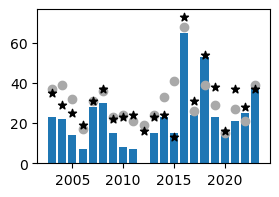

In [763]:
fig, ax = plt.subplots(figsize=(3,2))

plt.bar(years, pol_counts)
plt.scatter(years, win_counts, marker='o', c='darkgray')
# plt.scatter(years, win_counts2, marker='*', c='k')
plt.scatter(years, ice_counts, marker='*', c='k')
# plt.scatter(years, ice_counts)

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


(0.0, 3.0)

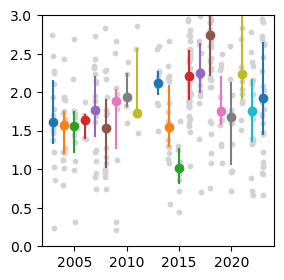

In [1226]:
fig, ax = plt.subplots(figsize=(3,3))


DF = dfr

years = np.arange(2003, 2024)

for year in years:

    COND = (DF.extent > 0) + (DF.event_day == -1)
    COND = (DF.extent > 0)
    COND[(DF.final_day)&(DF.single_day == False)] = False
    COND = COND & (DF.year == year)
    
#     COND = dir_conds(DF, 'wind')
#     COND = COND & (DF.year == year)
    
    
    winds_during = DF['s10'][COND]
    ice_during = DF['si'][COND]
    wf_during = (ice_during/winds_during)[winds_during>3]

    ax.scatter(year, np.nanpercentile(wf_during,50))
    
    bf = 0.1
    ax.scatter(np.linspace(year-bf, year+bf, len(wf_during)), wf_during, c='lightgray',s=10, zorder=-1)
    ax.plot([year,year], [np.nanpercentile(wf_during,25),np.nanpercentile(wf_during,75)])
    
#     ax.scatter(year, np.sum(COND))

plt.ylim(0,3)

NameError: name 'pol_stats' is not defined

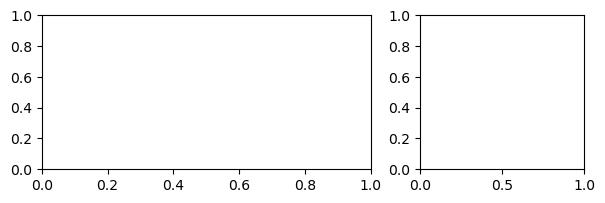

In [360]:
fig, axs = plt.subplots(1,2,figsize=(7,2), gridspec_kw={'width_ratios':[2,1]})


years = np.arange(2003,2026)
months = [12,1,2,3,4]

# total events per year
# annual_counts = [np.sum([pol_stats['counts'][month][year][0] for month in months]) for year in years]


mar1_kw = {'edgecolor': 'k', 'facecolor':'None', 'lw':1., 'marker':'D', 'zorder':10, 's':23}
mar2_kw = {'edgecolor': [0.65,0.65,0.65], 'facecolor':'None', 'lw':1.5, 'marker':'o', 's':35}


for yy, year in enumerate(years):
    
    month_colors = ['royalblue','skyblue','mediumpurple', 'lightcoral','r']
    
    last_num = 0
    
    cts_by_size = {}
    for q in ['q1','q2','q3','q4']:
        cts_by_size[q]=0
    for mm, month in enumerate(months):
        my_sizes = pol_stats['size'][month][year]
        cts_by_size['q1'] += np.sum((my_sizes > 0) & (my_sizes <= 155))
        cts_by_size['q2'] += np.sum((my_sizes > 155) & (my_sizes <= 500))
        cts_by_size['q3'] += np.sum((my_sizes > 500) & (my_sizes <= 1500))
        cts_by_size['q4'] += np.sum(my_sizes > 1500)

    ax = axs[0]
    last_num = 0
    for color, q in zip([c1,c2,c3,c4],['q1','q2','q3','q4']):
        current_num = cts_by_size[q]       
        ax.bar(year, current_num, bottom = last_num, color=color, alpha=0.75)
        last_num+=current_num
        
    if year <= 2024:
        total_WE = 0
        for mm, month in enumerate(months):
            total_WE += pol_stats['wind_events'][month][year][0]
        ax.scatter(year, total_WE, **mar1_kw)
    
    if year <= 2023:
        total_WE = 0
        for mm, month in enumerate(months):
            total_WE += pol_stats['ice_events'][month][year][0]
        ax.scatter(year, total_WE, **mar2_kw)

        
ax.set_ylim(0,95)
ax.bar(2012, ax.get_xlim()[-1], color='lightgray')
ax.set_xlim(2002.25,2025.75)
ax.set_ylabel('Days per\nconsolidated\nseason', rotation=0, labelpad=30, va='center')
ax.set_xlabel('Year')
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(30))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))


for mm, month in enumerate(months):
    
    cts_by_size = {}
    for q in ['q1','q2','q3','q4']:
        cts_by_size[q]=0
    for yy, year in enumerate(years):
        my_sizes = pol_stats['size'][month][year]
        cts_by_size['q1'] += np.sum((my_sizes > 0) & (my_sizes <= 155))
        cts_by_size['q2'] += np.sum((my_sizes > 155) & (my_sizes <= 500))
        cts_by_size['q3'] += np.sum((my_sizes > 500) & (my_sizes <= 1700))
        cts_by_size['q4'] += np.sum(my_sizes > 1700)
        
    days_per_year = 0
    for yy, year in enumerate(years):
        days_per_year+=pol_stats['days'][month][year]/len(years)
        
    days_per_year_ice = 0
    for yy, year in enumerate(years[:-2]):
        days_per_year_ice+=pol_stats['days'][month][year]/len(years[:-2])
        
    ax = axs[1]
    last_num = 0
    for color, q in zip([c1,c2,c3,c4],['q1','q2','q3','q4']):
        current_num = cts_by_size[q]/days_per_year
        ax.bar(mm, current_num, bottom = last_num, color=color, alpha=0.75)
        last_num+=current_num
        

    total_WE = 0
    for yy, year in enumerate(years[:-2]):
        total_WE += pol_stats['wind_events'][month][year][0]
    ax.scatter(mm, total_WE/days_per_year_ice, **mar1_kw)
    
    total_WE = 0
    for yy, year in enumerate(years[:-2]):
        total_WE += pol_stats['ice_events'][month][year][0]
    ax.scatter(mm, total_WE/days_per_year_ice, **mar2_kw)
    
    

    
# total_w = 0
#     for mm, month in enumerate(MONTHS):
#         total_w += np.sum(pol_stats['wind_events'][month][year])
#     all_we = np.append(all_we, np.sum(total_w))
    
#     total_i = 0
#     for mm, month in enumerate(MONTHS):
#         total_i += np.sum(pol_stats['ice_events'][month][year])
#     all_ie = np.append(all_ie, np.sum(total_i))
    
ax.set_ylabel('Days\nper\nmonth', rotation=0, labelpad=20, va='center')
ax.set_xlabel('Month')
ax.set_xticks(range(len(months)))
ax.set_xticklabels(['Dec','Jan','Feb','Mar','Apr'])
ax.set_ylim(0,7)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))


#     ax.scatter(year, cts_by_size['q1'])
#     ax.scatter(year, cts_by_size['q2'])
    
#     for mm, month in enumerate(months):
        
#         current_num = np.sum(pol_stats['counts'][month][year])            
#         ax.bar(year, current_num, bottom = last_num, color=month_colors[mm], alpha=0.75)
#         last_num += current_num


# plt.scatter(years, annual_counts, c='k')
        
# axs[0].set_ylim(2,18)

plt.subplots_adjust(wspace=0.1)


x = all_ie[(yearss>=2003)&(yearss<2024)]
y = all_pe[(yearss>=2003)&(yearss<2024)]
x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
resp = stats.linregress(x_nn,y_nn)
Rp = resp.rvalue

x = all_we[(yearss>=2003)&(yearss<2024)]
y = all_pe[(yearss>=2003)&(yearss<2024)]
x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
resa = stats.linregress(x_nn,y_nn)
Rw = resa.rvalue


ax = axs[0]
ax.scatter(2003.25,77, **mar1_kw)
ax.text(2003.25,77, f'  Wind events (R={Rw:.3f})', va='center')
ax.scatter(2003.25,87, **mar2_kw)
ax.text(2003.25,87, f'  Pack drift events (R={Rp:.3f})', va='center')


In [1231]:
10*units('km/day').to('m/s') / 0.015

<Quantity(7.71604938, 'meter / second')>

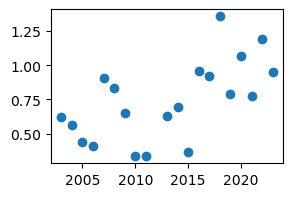

In [769]:
fig, ax = plt.subplots(figsize=(3,2))


ax.scatter(years, pol_counts/win_counts)


0.5187078095973269 0.2690577917372567
LinregressResult(slope=0.032539459719179716, intercept=-63.94543390471172, rvalue=0.5187078095973269, pvalue=0.015985384741568607, stderr=0.012304168528391326, intercept_stderr=24.768403307220904)
1.969684460908043
1.2574890942645234


Text(0.5, 0, 'Year')

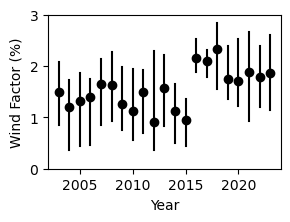

In [767]:

    
# plt.bar(years, pol_counts)
# plt.scatter(years, win_counts)

fig, ax = plt.subplots(figsize=(3,2))
x = years
y = wind_factors[50]


color = 'k'

for xx, yymin, yymax in zip(years, wind_factors[25], wind_factors[75]):
    plt.plot([xx,xx], [yymin,yymax], c=color)

x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
res = stats.linregress(x_nn,y_nn)
R = res.rvalue
ax.scatter(x,y, c=color)
x_line = np.array([x_nn.min(), x_nn.max()])
y_line = res.intercept + res.slope*x_line
print(R, R**2)
print(res)
# ax.plot(x_line, y_line);

med_pre16 = np.nanmedian(wf_match_years[years_match_wf<2016])
p75_pre16 = np.nanpercentile(wf_match_years[years_match_wf<2016], 75)
p25_pre16 = np.nanpercentile(wf_match_years[years_match_wf<2016], 25)

med_pst16 = np.nanmedian(wf_match_years[years_match_wf>=2016])
p75_pst16 = np.nanpercentile(wf_match_years[years_match_wf>=2016], 75)
p25_pst16 = np.nanpercentile(wf_match_years[years_match_wf>=2016], 25)


# ax.fill_between(x=[2003,2015], y1=p25_pre16, y2=p75_pre16, color='royalblue',  interpolate=True, alpha=.25, zorder=-1)
# plt.plot([2003,2015], [med_pre16, med_pre16], c='royalblue',  lw=2,zorder=-1)
# plt.plot([2003,2015], [p25_pre16, p25_pre16], c='royalblue',  lw=0.5,zorder=-1)
# plt.plot([2003,2015], [p75_pre16, p75_pre16], c='royalblue',  lw=0.5,zorder=-1)


# ax.fill_between(x=[2016,2023], y1=p25_pst16, y2=p75_pst16, color='red',  interpolate=True, alpha=.25, zorder=-1)
# plt.plot([2016,2023], [med_pst16, med_pst16], c='r', lw=2, zorder=-1)
# plt.plot([2016,2023], [p25_pst16, p25_pst16], c='r', lw=0.5, zorder=-1)
# plt.plot([2016,2023], [p75_pst16, p75_pst16], c='r', lw=0.5, zorder=-1)

print(med_pst16)
print(med_pre16)
# plt.fill_between([2016,2023], [p75_pre16, p25_pre16])
# avg_pre16 = np.nanmean(wind_factors[50][years<2016])

# plt.ylim(0,3)
ax.set_ylim(0,3)
plt.ylabel('Wind Factor (%)')
plt.xlabel('Year')

In [1035]:
np.nanmin(wind_factors[50])

0.4123069238884896

In [ ]:
np.nanmin(wind_factors[50])

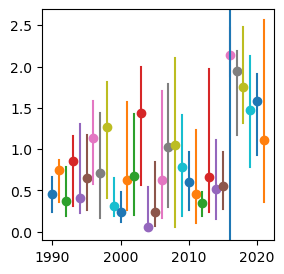

In [1105]:
DF = df[(df.year>=1987)&(df.year<2024)]

fig, ax = plt.subplots(figsize=(3,3))


# YEAR = 2013

month_cond = (DF.month == 3)
month_cond[DF.month == 2] = True
month_cond[DF.month == 4] = True

# month_cond = (DF.month == 12)
# month_cond[DF.month == 1] = True



# month_cond = DF.month < 100

for YEAR in np.arange(1990,2022):
    
    
    force_cond = ((DF['a10_r']>180) & (DF['a10_r']<300)) & (DF['s10']>3)
    
#     force_cond = (dir_conds(DF, 'wind')) & (DF['s10']>3)
    
    time_cond = (DF.year == YEAR) & month_cond
    COND = force_cond & time_cond
    values = (DF.si/DF.s10)[COND].values
    ax.scatter(YEAR, np.nanmedian(values))
    ax.plot([YEAR,YEAR], [np.nanpercentile(values,25), np.nanpercentile(values,75)])
    
    
#     time_cond = (DF.year < YEAR) & month_cond
#     COND = force_cond & time_cond
#     values1 = (DF.si/DF.s10)[COND].values

#     time_cond = (DF.year >= YEAR) & month_cond
#     COND = force_cond & time_cond
#     values2 = (DF.si/DF.s10)[COND].values

#     initial = np.nanmean(values1) / np.nanstd(values1)
#     final = np.nanmean(values2) / np.nanstd(values2)
    
#     plt.scatter(YEAR, abs(final-initial))

# plt.bar()

plt.axvline(2016)

(0.0, 15.0)

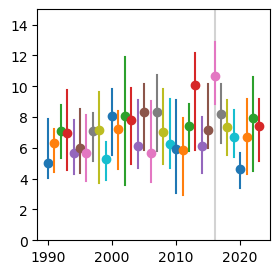

In [1081]:
DF = df[(df.year>=1988)&(df.year<2025)]

fig, ax = plt.subplots(figsize=(3,3))


# YEAR = 2013


# month_cond = (DF.month == 1)

month_cond = (DF.month == 3)
month_cond[DF.month == 2] = True
month_cond[DF.month == 4] = True

# month_cond = (DF.month == 12)
# month_cond[DF.month == 1] = True

for YEAR in np.arange(1990,2024):
    
    force_cond = dir_conds(DF, 'wind') #& (DF['s10']>0)
    
    time_cond = (DF.year == YEAR) & month_cond
    COND = force_cond & time_cond
    values = (DF.s10)[COND].values
    ax.scatter(YEAR, np.nanmedian(values))
    
    ax.plot([YEAR,YEAR], [np.nanpercentile(values,25), np.nanpercentile(values,75)])
    
    
#     time_cond = (DF.year < YEAR) & month_cond
#     COND = force_cond & time_cond
#     values1 = (DF.si/DF.s10)[COND].values

#     time_cond = (DF.year >= YEAR) & month_cond
#     COND = force_cond & time_cond
#     values2 = (DF.si/DF.s10)[COND].values

#     initial = np.nanmean(values1) / np.nanstd(values1)
#     final = np.nanmean(values2) / np.nanstd(values2)
    
#     plt.scatter(YEAR, abs(final-initial))

# plt.bar()

plt.axvline(2016, zorder=-1, c='lightgray')
plt.ylim(0,15)

In [447]:
df

,time,month,year,pre_2003,2003_2023,compact,open,q1,q2,q3,...,peak_day,event_length,after_event_length,before_event_length,esei,ese10,a10_r,ai_r,centermass_direction_r,max_length_direction_r
0,1987-12-01,12,1988,True,False,False,False,False,False,False,...,False,-999,-999,-999,0.363690,-1.445110,140.996915,226.351163,NaN,NaN
1,1987-12-02,12,1988,True,False,False,False,False,False,False,...,False,-999,-999,-999,1.577358,-5.139950,99.743757,270.815395,NaN,NaN
2,1987-12-03,12,1988,True,False,False,False,False,False,False,...,False,-999,-999,-999,1.029393,-4.541830,79.480123,345.129899,NaN,NaN
3,1987-12-04,12,1988,True,False,False,False,False,False,False,...,False,-999,-999,-999,-0.681007,-3.100055,76.052335,102.336540,NaN,NaN
4,1987-12-05,12,1988,True,False,False,False,False,False,False,...,False,-999,-999,-999,-0.355374,-4.107222,97.314999,185.202439,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5743,2025-04-26,4,2025,False,False,True,False,False,False,False,...,False,-999,-999,-999,NaN,17.953359,265.088243,NaN,90.0,90.0
5744,2025-04-27,4,2025,False,False,True,False,False,False,False,...,False,-999,-999,-999,NaN,13.530845,255.125687,NaN,90.0,90.0
5745,2025-04-28,4,2025,False,False,True,False,False,False,False,...,False,-999,-999,-999,NaN,7.978714,249.709913,NaN,90.0,90.0
5746,2025-04-29,4,2025,False,False,True,False,False,False,False,...,False,-999,-999,-999,NaN,NaN,NaN,NaN,90.0,90.0


In [252]:
np.sum(speed_range&wind_dir_cond)

0

In [251]:
DF['extent'][speed_range&wind_dir_cond].values

array([], dtype=float64)

-3.097959422289935 3.097959422289935 3.141592653589793
a10
[-180  145  150  155  160  165  170  175]
-3.097959422289935 3.097959422289935 3.141592653589793
ai
[135 140 145 150 155 160 165 170 175]
-3.097959422289935 3.097959422289935 3.141592653589793
centermass_direction
[120 125 130 135 140 145 150 155]


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_55175/2228769708.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['E','','N','','W ','','S'])
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_55175/2228769708.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['E','','N','','W ','','S'])
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_55175/2228769708.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['E','','N','','W ','','S'])


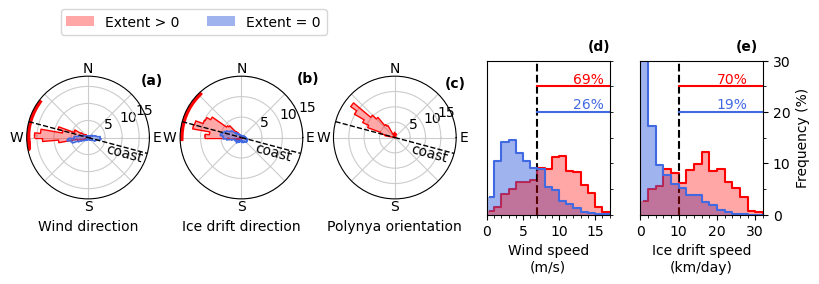

In [1758]:

# create plot
fig, axs = plt.subplots(1,5, figsize=(9.5,2), subplot_kw={'projection': None})

# Override specific subplots to be polar using add_subplot
fig.delaxes(axs[0])
fig.delaxes(axs[1])
fig.delaxes(axs[2])
axs[0] = fig.add_subplot(1, 5, 1, projection='polar')
axs[1] = fig.add_subplot(1, 5, 2, projection='polar')
axs[2] = fig.add_subplot(1, 5, 3, projection='polar')


#============
DF = dfb

# DF = df[(df.year>=2003)&(df.year<2016)]
# DF = df[(df.year>=2016)&(df.year<2026)]
#============

# ccolor = c2
ccolor = 'royalblue'
bcolor = 'red'

bins = np.arange(-180,181,5)
comp_ = (DF.extent==0)
open_ = (DF.extent>0)#&(not_last_day)


ICE_THRESH = 10
WIND_THRESH = 7


for ax, group, color in zip(axs[0:3], ['a10', 'ai', 'centermass_direction'], [bcolor,bcolor, bcolor]):
    
    # Plot bars
    x = DF[f'{group}'][open_]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers'] * np.pi/180
    width = h2['w']* np.pi/180
    ax.bar(theta, 100*h2['prob'], width=width, bottom=0.0, alpha=0.35, color=bcolor, zorder=3, label='Extent > 0')
    ax.step(theta, 100*h2['prob'], where='mid', alpha=1, color=bcolor,lw=1, zorder=3)
    ax.plot([-np.pi, -np.pi], [100*h2['prob'][0], 100*h2['prob'][-1]], alpha=1, color=bcolor,lw=1, zorder=3)
    ax.plot([theta[-1], -np.pi], [100*h2['prob'][-1], 100*h2['prob'][-1]], alpha=1, color=bcolor,lw=1, zorder=3)
    print(theta[0], theta[-1], np.pi)
    
    if group!= 'centermass_direction':
        x = DF[f'{group}'][comp_]
        h = plotter.quick_hist(x, bin_edges = bins)
        theta = h['centers'] * np.pi/180
        ax.bar(theta, 100*h['prob'], width=width, bottom=0.0, alpha=0.5, color=ccolor, zorder=4, label='Extent = 0')
        ax.step(theta, 100*h['prob'], where='mid', alpha=1, color=ccolor,lw=1, zorder=4)
        ax.plot([-np.pi, -np.pi], [100*h['prob'][0], 100*h['prob'][-1]], alpha=1, color=ccolor,lw=1, zorder=4)
        ax.plot([theta[-1], -np.pi], [100*h['prob'][-1], 100*h['prob'][-1]], alpha=1, color=ccolor,lw=1, zorder=4)
    
    
    print(group)
    print(h2['edges'][:-1][(h2['prob']>1.5*h['prob'])&(h2['prob']>0.02)])
    
#     ax.plot(theta, 100*h2['prob'], alpha=1, color=color, marker='.', zorder=-1)
#     ax.plot(theta, 100*h['prob'], alpha=1, color=bcolor, marker='.', zorder=-1)
    
axs[0].set_ylim(0,18)
axs[1].set_ylim(0,15)
axs[2].set_ylim(0,20)


for ax, R in zip(axs[0:3], [5,3,5]):
    ax.set_yticks([5,10,15])
    ax.set_yticklabels([5,10,15])
#     ax.set_yticklabels(['',5,''], color=bcolor)
    ax.set_theta_zero_location("E")  # Set 0 at the top
    ax.set_theta_direction(1)  # Clockwise direction
    ax.set_axisbelow(True) 
    ax.grid(color=[0.8,0.8,0.8])
    
#     ax.grid(True, zorder=-10001)
    
    ax.set_xticklabels(['E','','N','','W ','','S'])
    ax.tick_params(axis='x', pad=-5)

    # coastline orientation
    th = -15*np.pi/180
    ax.plot([th, th], [0,ax.get_ylim()[1]], c='k', ls='dashed', lw=1, zorder=100)
    ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='k', ls='dashed', lw=1, zorder=100)
    ax.text(-15*np.pi/180, R, 'coast', rotation = -15, va='top')
    
ax = axs[0]
th1 = -170*np.pi/180
th2 = 145*np.pi/180
ax.plot(np.append(np.linspace(-np.pi,th1,10), np.linspace(th2, np.pi,10)[::-1]), 
        np.full(20,ax.get_ylim()[1]), c=color, ls='solid', lw=5)
ax.set_xlabel('Wind direction') 

ax = axs[1]
th1 = -180*np.pi/180
th2 = 135*np.pi/180
ax.plot(np.append(np.linspace(-np.pi,th1,10), np.linspace(th2, np.pi,10)[::-1]), 
        np.full(20,ax.get_ylim()[1]), c=color, ls='solid', lw=5)
ax.set_xlabel('Ice drift direction') 


ax = axs[2]
# th1 = -180*np.pi/180
# th2 = 135*np.pi/180
# ax.plot(np.append(np.linspace(-np.pi,th1,10), np.linspace(th2, np.pi,10)[::-1]), 
#         np.full(20,ax.get_ylim()[1]), c=color, ls='solid', lw=5)
ax.set_xlabel('Polynya orientation') 

for ax, group, color, bins in zip(axs[3:], ['s10', 'si_km'], [ccolor,ccolor], 
                                  [np.arange(0,19,1), np.arange(0,41,2)]):
    
    x = DF[f'{group}'][comp_]
    h = plotter.quick_hist(x, bin_edges = bins)

    x = DF[f'{group}'][open_]
    h2 = plotter.quick_hist(x, bin_edges = bins)


    ax.bar(h2['centers'], 100*h2['prob'], width=h2['w'], bottom=0.0, alpha=0.35, color=bcolor, zorder=0, label='Extent > 0')
    ax.step(h2['centers'], 100*h2['prob'], where='mid', alpha=1, color=bcolor, zorder=-1)
    
    # Plot bars
    ax.bar(h['centers'], 100*h['prob'], width=h['w'], bottom=0.0, alpha=0.5, color=color, zorder=-1, label='Extent = 0')
    ax.step(h['centers'], 100*h['prob'], where='mid', alpha=1, color=color, zorder=0)

    yy = 15
    
#     dst = DF[f's{group}']
    
    
#     ax.axvline(np.nanpercentile(dst, 50), c='k', zorder=-1)
#     ax.axvline(np.nanpercentile(dst, 25), c='k', zorder=-1, ls='dashed', lw=1)
#     ax.axvline(np.nanpercentile(dst, 75), c='k', zorder=-1, ls='dashed', lw=1)
    
#     ax.fill_betweenx([0,40],np.nanpercentile(dst, 25), np.nanpercentile(dst, 75), 
#                     color='k', alpha=0.15, lw=0, zorder=-1)
    
    
axs[3].axvline(WIND_THRESH, c='k', ls='dashed', zorder=-1)
axs[4].axvline(ICE_THRESH, c='k', ls='dashed', zorder=-1)

yy = 25
axs[3].plot([WIND_THRESH,17], [yy,yy], c=bcolor)
axs[3].text(12, yy, f'{100*np.sum(DF[open_]['s10']>WIND_THRESH)/np.sum(open_):.0f}%',  c=bcolor, va='bottom')
yy = 20
axs[3].plot([WIND_THRESH,17], [yy,yy], c=ccolor)
axs[3].text(12, yy, f'{100*np.sum(DF[comp_]['s10']>WIND_THRESH)/np.sum(comp_):.0f}%',  c=ccolor, va='bottom')


yy = 25
axs[4].plot([ICE_THRESH,40], [yy,yy], c=bcolor)
axs[4].text(20, yy, f'{100*np.sum(DF[open_]['si_km']>ICE_THRESH)/np.sum(open_):.0f}%',  c=bcolor, va='bottom')
yy = 20
axs[4].plot([ICE_THRESH,40], [yy,yy], c=ccolor)
axs[4].text(20, yy, f'{100*np.sum(DF[comp_]['si_km']>ICE_THRESH)/np.sum(comp_):.0f}%',  c=ccolor, va='bottom')



    
axs[0].legend(ncols=2, bbox_to_anchor=(2.5,1.6))

    
ax = axs[3]
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.set_yticks([])
ax.set_xlabel('Wind speed\n(m/s)')  
ax.set_xlim(0,17)
ax.set_ylim(0,30)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

ax = axs[4]
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.set_xlabel('Ice drift speed\n(km/day)')  
ax.set_ylabel('Frequency (%)')  
plt.subplots_adjust(wspace=0.25)
ax.set_xlim(0,32)
ax.set_ylim(0,30)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")



axs[0].text(np.pi/4, 22, '(a)', weight='bold', clip_on=False)
axs[1].text(np.pi/4, 19, '(b)', weight='bold', clip_on=False)
axs[2].text(np.pi/4, 23, '(c)', weight='bold', clip_on=False)
axs[3].text(14, 32, '(d)', weight='bold', clip_on=False)
axs[4].text(25, 32, '(e)', weight='bold', clip_on=False)

# fig.savefig('../figures/results/forcing_distributions_v2.png', dpi=400, bbox_inches='tight', pad_inches=0)
